In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as Image
from skimage import feature
import os
import math
from sklearn.decomposition import PCA 
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import cross_val_score
import optuna
import random
%matplotlib notebook 

def walk(path):
    table=[]
    if not os.path.exists(path):
        return -1
    for root,dirs,names in os.walk(path):
        for filename in names:
            table.append(os.path.join(root,filename))
    table.sort()
    return table

def Image_bound(img_table,label):
    img_bound=[]
    #garder que les parties du bounding box
    for i in range(len(img_table)):
        x1,y1,x2,y2=label[i]["box"]
        #print(x1,y1,x2,y2)
        img_bound.append(img_table[i][int(y1):int(y2),int(x1):int(x2)])
        #print(img_table[i].shape)
        """plt.imshow(img_bound[i],cmap='gray')
        plt.show()"""
    return img_bound
    
def calculer_hog(img_t,resize_x,resize_y,nb_bins,nbpixels_x,nbpixels_y,nbcelles_x,nbcelles_y):
    hog_vector=[]
    hog_image=[]
    for i in range(len(img_t)):
        img=cv2.resize(img_t[i],(resize_x,resize_y))
        fd, h =hog(img, orientations=nb_bins, pixels_per_cell=(nbpixels_x,nbpixels_y),
                           cells_per_block=(nbcelles_x, nbcelles_y), visualize=True)
        hog_vector.append(np.array(fd))
        hog_image.append(h)
    return hog_vector,hog_image

def calculer_orb(img_t,resize_x,resize_y,nf=500,eT=31,pS=31,fs=40):
    orb_vector=[]
    orb = cv2.ORB_create(nfeatures=nf,edgeThreshold=eT,patchSize=pS,fastThreshold=fs)  
    for i in range(len(img_t)):
        img=cv2.resize(img_table[i],(resize_x,resize_y))
        kp2, des = orb.detectAndCompute(img, None)
        des.resize((des.shape[0]*des.shape[1])) 
        orb_vector.append(des)
    return orb_vector
    
def vector_to_matrice(vector_table):
    mat=np.array([])
    for i in range(len(vector_table)):
        try:
            mat=np.vstack((mat,vector_table[i]))
        except:   
            mat=vector_table[i]
    return mat


def plot_scatter(data,k=4,plot=False):
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,200,0.0001)
    ret,labels,center=cv2.kmeans(np.float32(data),k,None,criteria,100,cv2.KMEANS_RANDOM_CENTERS)
    if(plot):
        colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
        for i in range(8):
            plt.scatter(data[labels.ravel()==i][:,0],data[labels.ravel()==i][:,1],c=colors[i])
            plt.scatter(center[:,0],center[:,1],s = 80,c = 'y', marker = 's')
        #plt.savefig('B_(32,32)_(8,8)_8_kmean')
        plt.show()
        for i in range(len(data)):
            plt.scatter(data[i][0],data[i][1],c=colors[label[i]["direction"]-1])
        #plt.scatter(center[:,0],center[:,1],s = 80,c = 'y', marker = 's')
        #plt.savefig('B_(32,32)_(8,8)_8_dataset')
        plt.show()
    return labels


def equilibrate_sample(nb_model,nb_image_par_direction):
    img_table=[]
    label={}
    model_table=[]
    label_table=[]
    for root,dirs,names in os.walk("data/image"):
        if(len(root.split('/'))==4):
            model_table.append(root)
    model_table.sort()
    for root,dirs,names in os.walk("data/label"):
        if(len(root.split('/'))==4):
            label_table.append(root)
    label_table.sort()
    N=nb_image_par_direction*5
    nb_sample=0
    index_model=0
    while(index_model<nb_model):
        m = random.sample(range(1, len(model_table)), 1)[0]
        imgpath = walk(model_table[m])
        if(len(imgpath)<N):
            continue
        print(m)
        model={}
        labelpath = walk(label_table[m])
        essay=0
        while(nb_sample<N*(index_model+1) and essay<N*20):
            i = random.sample(range(1, len(imgpath)), 1)[0]
            essay += 1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
            file_object = open(labelpath[i])
            lines = file_object.readlines()
            try:
                direction=int(lines[0][0])
            except:
                continue
            if(direction not in model.keys()):
                model[direction]=1
            else:
                if(model[direction] < nb_image_par_direction):
                        model[direction] += 1
                else:
                    continue
            label[nb_sample] = {}
            label[nb_sample]["direction"] = direction
            label[nb_sample]["box"] = lines[2].split()
            img_table.append(cv2.imread(imgpath[i],cv2.IMREAD_GRAYSCALE))    
            nb_sample += 1
        print(model)
        index_model+=1  
    return img_table,label

def read_image_label(image_dir_table,label_dir_table):
    img_table=[] 
    label={}
    a=0
    for i in range(len(image_dir_table)):
        path_image=image_dir_table[i]
        path_label=label_dir_table[i]
        imgpath=walk(path_image)
        labelpath=walk(path_label)
        for j in imgpath:
            img_table.append(cv2.imread(j,cv2.IMREAD_GRAYSCALE))
        for x in labelpath:
            label[a]={}
            file_object=open(x)
            lines = file_object.readlines()
            label[a]["direction"]=int(lines[0].split()[0])
            label[a]["box"]=lines[2].split()
            a+=1
    return img_table,label

def calculate_contingency_table(label_kmeans,label):
    contingency_table=np.zeros((5,len(np.unique(label_kmeans))))
    dic={}
    for i in range(len(label_kmeans)):
        dic[label[i]["direction"]]={}
    for i in range(len(label_kmeans)):
        try:
            dic[label[i]["direction"]]["%d"%label_kmeans[i][0]]+=1
        except:
            dic[label[i]["direction"]]["%d"%label_kmeans[i][0]]=1
    print(dic)
    for key in dic.keys():
        for k in dic[key].keys():
            contingency_table[key-1,int(k)-1]+=dic[key][k]
    return contingency_table

def adjusted_rand(contingency_table,N):
    row_sum=contingency_table.sum(axis=0)
    column_sum=contingency_table.sum(axis=1)
    sum_ij=(contingency_table*np.where(contingency_table==0,0,contingency_table-1)/2).sum()
    sum_ai=(row_sum*np.where(row_sum==0,0,row_sum-1)/2).sum()
    sum_bi=(row_sum*np.where(row_sum==0,0,row_sum-1)/2).sum()
    ARI=(sum_ij-(sum_ai*sum_bi)/((N*N-1)*2))/((0.5*(sum_ai+sum_bi))-(sum_ai*sum_bi)/((N*N-1)*2))
    return ARI

def cloest_centroid(vector,centroid_table):
    distance=((centroid_table-vector)**2).sum(axis=1)
    return np.argmin(distance)

"""Métrique de K-moyenne"""
import optuna
def objective(trial,index,patch,accuracy):
    num_pca=trial.suggest_discrete_uniform("num_pca",0.5,0.99,0.01)
    num_cluster=trial.suggest_int("num_cluster",3,50)
    Xtrain, Xtest, ytrain, ytest = train_test_split(patch[index], labels,random_state=0)
    bound=vector_to_matrice(Xtrain)
    p=PCA(n_components=num_pca)
    pca_bound=preprocessing.normalize(p.fit_transform(bound))
    kmeans = KMeans(n_clusters=num_cluster, random_state=0)
    clusters= kmeans.fit_predict(pca_bound)
    mat = confusion_matrix(ytrain,clusters)
    link={}
    for i in range(mat.shape[0]):
        link[str(i)]=np.argmax(mat[:,i])
    test=vector_to_matrice(Xtest)
    test=p.transform(test)
    acc=np.zeros(5)
    state=np.zeros(5)
    for i in range(len(test)):
        state[ytest[i]-1]+=1
        if(link[str(cloest_centroid(test[i],kmeans.cluster_centers_))]==ytest[i]):
            acc[ytest[i]-1]+=1
    score=acc.sum()/len(test)
    accuracy.append(acc/state)
    return score

def objective_rf(trial,index,patch,accuracy):
    num_pca=trial.suggest_discrete_uniform("num_pca",0.5,0.99,0.01)
    num_estimators=trail.suggest_int("num_estimator",10,100)
    rf=RandomForestClassifier(n_estimators=num_estimator,random_state=0)
    Xtrain, Xtest, ytrain, ytest = train_test_split(patch[index], labels,random_state=0)
    bound=vector_to_matrice(Xtrain)
    test=vector_to_matrice(Xtest)
    p=PCA(n_components=0.9)
    pca_bound=preprocessing.normalize(p.fit_transform(bound))
    rf.fit(pca_bound,ytrain)
    test=p.transform(test)
    res=rf.predict(test)
    acc=np.zeros(5)
    state=np.zeros(5)
    for i in range(len(res)):
        state[ytest[i]-1]+=1
        if(res[i]==ytest[i]):
            accuracy[ytest[i]-1]+=1
    score=acc.sum()/len(test)
    accuracy.append(acc/state)
    return score


In [3]:
path_dir="data/image"
label_dir="data/label"
img_table,label=equilibrate_sample(20,2)
img_bound=Image_bound(img_table,label)
labels=[]
for i in label.keys():
    labels.append(label[i]["direction"])

1106
{5: 2, 1: 2, 4: 2, 3: 2, 2: 2}
229
{4: 2, 3: 2, 5: 2, 1: 2, 2: 2}
1346
{4: 2, 2: 2, 5: 2, 1: 2, 3: 2}
1660
{3: 2, 5: 2, 2: 2, 4: 2, 1: 2}
1578
{2: 2, 4: 2, 1: 2, 5: 2, 3: 2}
545
{4: 2, 5: 2, 2: 2, 1: 2, 3: 2}
490
{1: 2, 4: 2, 3: 2, 5: 2}
483
{5: 2, 4: 2, 3: 2, 1: 2}
639
{1: 2, 4: 2, 3: 2, 5: 2}
1452
{4: 2, 5: 2, 1: 2, 2: 2, 3: 2}
267
{3: 2, 4: 2, 1: 2, 5: 2, 2: 2}
415
{2: 2, 4: 2, 5: 2, 3: 2, 1: 2}
1426
{2: 2, 5: 2, 3: 2, 4: 2, 1: 2}
73
{5: 2, 3: 2, 4: 2, 1: 2, 2: 2}
520
{4: 2, 1: 2, 5: 2, 3: 2, 2: 2}
1069
{4: 2, 5: 2, 3: 2, 1: 2, 2: 2}
274
{4: 2, 5: 2, 1: 2, 3: 2, 2: 2}
988
{4: 2, 1: 2, 5: 2, 3: 2, 2: 2}
1380
{3: 2, 4: 2, 1: 2, 5: 2, 2: 2}
747
{4: 2, 5: 2, 1: 2, 3: 2, 2: 2}


In [4]:
hp1=[]
for  i in range(20,130,10):
    hp1.append(calculer_hog(img_bound,512,512,6,i,i,1,1)[0])
    print("1 :",i)
hp2=[]
for  i in range(20,130,10):
    hp2.append(calculer_hog(img_bound,512,512,6,i,i,2,2)[0])
    print("2 :",i)
hp3=[]
for  i in range(20,130,10):
    hp3.append(calculer_hog(img_bound,512,512,6,i,i,3,3)[0])
    print("3 :",i)
hp4=[]
for  i in range(20,130,10):
    hp4.append(calculer_hog(img_bound,512,512,6,i,i,4,4)[0])
    print("4 :",i)


1 : 20
1 : 30
1 : 40
1 : 50
1 : 60
1 : 70
1 : 80
1 : 90
1 : 100
1 : 110
1 : 120
2 : 20
2 : 30
2 : 40
2 : 50
2 : 60
2 : 70
2 : 80
2 : 90
2 : 100
2 : 110
2 : 120
3 : 20
3 : 30
3 : 40
3 : 50
3 : 60
3 : 70
3 : 80
3 : 90
3 : 100
3 : 110
3 : 120
4 : 20
4 : 30
4 : 40
4 : 50
4 : 60
4 : 70
4 : 80
4 : 90
4 : 100
4 : 110
4 : 120


In [4]:
op_v1=[]
op_p1=[]
for i in range(len(hp1)):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial:objective(trial,i,hp1), n_trials=100)
    op_v1.append(study.best_value)
    op_p1.append(study.best_params)

[I 2020-03-23 01:54:03,401] Finished trial#0 resulted in value: 0.5918367346938775. Current best value is 0.5918367346938775 with parameters: {'num_pca': 0.63, 'num_cluster': 12}.
[I 2020-03-23 01:54:03,601] Finished trial#1 resulted in value: 0.5306122448979592. Current best value is 0.5918367346938775 with parameters: {'num_pca': 0.63, 'num_cluster': 12}.
[I 2020-03-23 01:54:03,762] Finished trial#2 resulted in value: 0.5714285714285714. Current best value is 0.5918367346938775 with parameters: {'num_pca': 0.63, 'num_cluster': 12}.
[I 2020-03-23 01:54:03,982] Finished trial#3 resulted in value: 0.4489795918367347. Current best value is 0.5918367346938775 with parameters: {'num_pca': 0.63, 'num_cluster': 12}.
[I 2020-03-23 01:54:04,168] Finished trial#4 resulted in value: 0.5714285714285714. Current best value is 0.5918367346938775 with parameters: {'num_pca': 0.63, 'num_cluster': 12}.
[I 2020-03-23 01:54:04,324] Finished trial#5 resulted in value: 0.5102040816326531. Current best val

[I 2020-03-23 01:54:19,244] Finished trial#90 resulted in value: 0.5714285714285714. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.64, 'num_cluster': 11}.
[I 2020-03-23 01:54:19,434] Finished trial#91 resulted in value: 0.673469387755102. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.64, 'num_cluster': 11}.
[I 2020-03-23 01:54:19,599] Finished trial#92 resulted in value: 0.5714285714285714. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.64, 'num_cluster': 11}.
[I 2020-03-23 01:54:19,757] Finished trial#93 resulted in value: 0.40816326530612246. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.64, 'num_cluster': 11}.
[I 2020-03-23 01:54:19,925] Finished trial#94 resulted in value: 0.5714285714285714. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.64, 'num_cluster': 11}.
[I 2020-03-23 01:54:20,094] Finished trial#95 resulted in value: 0.5918367346938775. Current be

[I 2020-03-23 01:54:33,133] Finished trial#80 resulted in value: 0.6326530612244898. Current best value is 0.673469387755102 with parameters: {'num_pca': 0.64, 'num_cluster': 15}.
[I 2020-03-23 01:54:33,293] Finished trial#81 resulted in value: 0.5306122448979592. Current best value is 0.673469387755102 with parameters: {'num_pca': 0.64, 'num_cluster': 15}.
[I 2020-03-23 01:54:33,464] Finished trial#82 resulted in value: 0.5306122448979592. Current best value is 0.673469387755102 with parameters: {'num_pca': 0.64, 'num_cluster': 15}.
[I 2020-03-23 01:54:33,624] Finished trial#83 resulted in value: 0.5102040816326531. Current best value is 0.673469387755102 with parameters: {'num_pca': 0.64, 'num_cluster': 15}.
[I 2020-03-23 01:54:33,784] Finished trial#84 resulted in value: 0.5918367346938775. Current best value is 0.673469387755102 with parameters: {'num_pca': 0.64, 'num_cluster': 15}.
[I 2020-03-23 01:54:33,942] Finished trial#85 resulted in value: 0.6122448979591837. Current best va

[I 2020-03-23 01:54:46,391] Finished trial#70 resulted in value: 0.5510204081632653. Current best value is 0.673469387755102 with parameters: {'num_pca': 0.75, 'num_cluster': 14}.
[I 2020-03-23 01:54:46,543] Finished trial#71 resulted in value: 0.5102040816326531. Current best value is 0.673469387755102 with parameters: {'num_pca': 0.75, 'num_cluster': 14}.
[I 2020-03-23 01:54:46,700] Finished trial#72 resulted in value: 0.6530612244897959. Current best value is 0.673469387755102 with parameters: {'num_pca': 0.75, 'num_cluster': 14}.
[I 2020-03-23 01:54:46,854] Finished trial#73 resulted in value: 0.5510204081632653. Current best value is 0.673469387755102 with parameters: {'num_pca': 0.75, 'num_cluster': 14}.
[I 2020-03-23 01:54:47,009] Finished trial#74 resulted in value: 0.6530612244897959. Current best value is 0.673469387755102 with parameters: {'num_pca': 0.75, 'num_cluster': 14}.
[I 2020-03-23 01:54:47,167] Finished trial#75 resulted in value: 0.5102040816326531. Current best va

[I 2020-03-23 01:54:59,163] Finished trial#60 resulted in value: 0.5510204081632653. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.76, 'num_cluster': 15}.
[I 2020-03-23 01:54:59,315] Finished trial#61 resulted in value: 0.6530612244897959. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.76, 'num_cluster': 15}.
[I 2020-03-23 01:54:59,466] Finished trial#62 resulted in value: 0.5918367346938775. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.76, 'num_cluster': 15}.
[I 2020-03-23 01:54:59,615] Finished trial#63 resulted in value: 0.5306122448979592. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.76, 'num_cluster': 15}.
[I 2020-03-23 01:54:59,759] Finished trial#64 resulted in value: 0.6938775510204082. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.76, 'num_cluster': 15}.
[I 2020-03-23 01:54:59,915] Finished trial#65 resulted in value: 0.673469387755102. Current bes

[I 2020-03-23 01:55:11,257] Finished trial#50 resulted in value: 0.6122448979591837. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.77, 'num_cluster': 8}.
[I 2020-03-23 01:55:11,428] Finished trial#51 resulted in value: 0.5714285714285714. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.77, 'num_cluster': 8}.
[I 2020-03-23 01:55:11,553] Finished trial#52 resulted in value: 0.4897959183673469. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.77, 'num_cluster': 8}.
[I 2020-03-23 01:55:11,675] Finished trial#53 resulted in value: 0.4489795918367347. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.77, 'num_cluster': 8}.
[I 2020-03-23 01:55:11,817] Finished trial#54 resulted in value: 0.5510204081632653. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.77, 'num_cluster': 8}.
[I 2020-03-23 01:55:11,940] Finished trial#55 resulted in value: 0.6326530612244898. Current best va

[I 2020-03-23 01:55:23,177] Finished trial#38 resulted in value: 0.4897959183673469. Current best value is 0.673469387755102 with parameters: {'num_pca': 0.64, 'num_cluster': 15}.
[I 2020-03-23 01:55:23,317] Finished trial#39 resulted in value: 0.5510204081632653. Current best value is 0.673469387755102 with parameters: {'num_pca': 0.64, 'num_cluster': 15}.
[I 2020-03-23 01:55:23,437] Finished trial#40 resulted in value: 0.6122448979591837. Current best value is 0.673469387755102 with parameters: {'num_pca': 0.64, 'num_cluster': 15}.
[I 2020-03-23 01:55:23,571] Finished trial#41 resulted in value: 0.5306122448979592. Current best value is 0.673469387755102 with parameters: {'num_pca': 0.64, 'num_cluster': 15}.
[I 2020-03-23 01:55:23,705] Finished trial#42 resulted in value: 0.5510204081632653. Current best value is 0.673469387755102 with parameters: {'num_pca': 0.64, 'num_cluster': 15}.
[I 2020-03-23 01:55:23,835] Finished trial#43 resulted in value: 0.5918367346938775. Current best va

[I 2020-03-23 01:55:35,201] Finished trial#28 resulted in value: 0.673469387755102. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.7, 'num_cluster': 12}.
[I 2020-03-23 01:55:35,335] Finished trial#29 resulted in value: 0.5510204081632653. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.7, 'num_cluster': 12}.
[I 2020-03-23 01:55:35,465] Finished trial#30 resulted in value: 0.5714285714285714. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.7, 'num_cluster': 12}.
[I 2020-03-23 01:55:35,602] Finished trial#31 resulted in value: 0.5510204081632653. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.7, 'num_cluster': 12}.
[I 2020-03-23 01:55:35,739] Finished trial#32 resulted in value: 0.6122448979591837. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.7, 'num_cluster': 12}.
[I 2020-03-23 01:55:35,875] Finished trial#33 resulted in value: 0.5918367346938775. Current best val

[I 2020-03-23 01:55:47,340] Finished trial#18 resulted in value: 0.5918367346938775. Current best value is 0.5918367346938775 with parameters: {'num_pca': 0.79, 'num_cluster': 9}.
[I 2020-03-23 01:55:47,467] Finished trial#19 resulted in value: 0.6122448979591837. Current best value is 0.6122448979591837 with parameters: {'num_pca': 0.72, 'num_cluster': 11}.
[I 2020-03-23 01:55:47,597] Finished trial#20 resulted in value: 0.5510204081632653. Current best value is 0.6122448979591837 with parameters: {'num_pca': 0.72, 'num_cluster': 11}.
[I 2020-03-23 01:55:47,725] Finished trial#21 resulted in value: 0.5306122448979592. Current best value is 0.6122448979591837 with parameters: {'num_pca': 0.72, 'num_cluster': 11}.
[I 2020-03-23 01:55:47,864] Finished trial#22 resulted in value: 0.4489795918367347. Current best value is 0.6122448979591837 with parameters: {'num_pca': 0.72, 'num_cluster': 11}.
[I 2020-03-23 01:55:47,997] Finished trial#23 resulted in value: 0.5918367346938775. Current bes

[I 2020-03-23 01:55:58,969] Finished trial#8 resulted in value: 0.5714285714285714. Current best value is 0.6530612244897959 with parameters: {'num_pca': 0.53, 'num_cluster': 15}.
[I 2020-03-23 01:55:59,089] Finished trial#9 resulted in value: 0.5510204081632653. Current best value is 0.6530612244897959 with parameters: {'num_pca': 0.53, 'num_cluster': 15}.
[I 2020-03-23 01:55:59,222] Finished trial#10 resulted in value: 0.5102040816326531. Current best value is 0.6530612244897959 with parameters: {'num_pca': 0.53, 'num_cluster': 15}.
[I 2020-03-23 01:55:59,359] Finished trial#11 resulted in value: 0.5510204081632653. Current best value is 0.6530612244897959 with parameters: {'num_pca': 0.53, 'num_cluster': 15}.
[I 2020-03-23 01:55:59,473] Finished trial#12 resulted in value: 0.6530612244897959. Current best value is 0.6530612244897959 with parameters: {'num_pca': 0.53, 'num_cluster': 15}.
[I 2020-03-23 01:55:59,585] Finished trial#13 resulted in value: 0.5510204081632653. Current best

[I 2020-03-23 01:56:10,767] Finished trial#98 resulted in value: 0.6326530612244898. Current best value is 0.6530612244897959 with parameters: {'num_pca': 0.53, 'num_cluster': 15}.
[I 2020-03-23 01:56:10,911] Finished trial#99 resulted in value: 0.5918367346938775. Current best value is 0.6530612244897959 with parameters: {'num_pca': 0.53, 'num_cluster': 15}.
[I 2020-03-23 01:56:11,028] Finished trial#0 resulted in value: 0.5510204081632653. Current best value is 0.5510204081632653 with parameters: {'num_pca': 0.99, 'num_cluster': 9}.
[I 2020-03-23 01:56:11,136] Finished trial#1 resulted in value: 0.42857142857142855. Current best value is 0.5510204081632653 with parameters: {'num_pca': 0.99, 'num_cluster': 9}.
[I 2020-03-23 01:56:11,259] Finished trial#2 resulted in value: 0.5918367346938775. Current best value is 0.5918367346938775 with parameters: {'num_pca': 0.98, 'num_cluster': 11}.
[I 2020-03-23 01:56:11,378] Finished trial#3 resulted in value: 0.46938775510204084. Current best v

[I 2020-03-23 01:56:21,292] Finished trial#85 resulted in value: 0.6122448979591837. Current best value is 0.6530612244897959 with parameters: {'num_pca': 0.8400000000000001, 'num_cluster': 14}.
[I 2020-03-23 01:56:21,419] Finished trial#86 resulted in value: 0.4489795918367347. Current best value is 0.6530612244897959 with parameters: {'num_pca': 0.8400000000000001, 'num_cluster': 14}.
[I 2020-03-23 01:56:21,563] Finished trial#87 resulted in value: 0.5918367346938775. Current best value is 0.6530612244897959 with parameters: {'num_pca': 0.8400000000000001, 'num_cluster': 14}.
[I 2020-03-23 01:56:21,704] Finished trial#88 resulted in value: 0.4897959183673469. Current best value is 0.6530612244897959 with parameters: {'num_pca': 0.8400000000000001, 'num_cluster': 14}.
[I 2020-03-23 01:56:21,844] Finished trial#89 resulted in value: 0.4897959183673469. Current best value is 0.6530612244897959 with parameters: {'num_pca': 0.8400000000000001, 'num_cluster': 14}.
[I 2020-03-23 01:56:21,96

[I 2020-03-23 01:56:32,803] Finished trial#74 resulted in value: 0.5510204081632653. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.51, 'num_cluster': 13}.
[I 2020-03-23 01:56:32,937] Finished trial#75 resulted in value: 0.5306122448979592. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.51, 'num_cluster': 13}.
[I 2020-03-23 01:56:33,070] Finished trial#76 resulted in value: 0.5510204081632653. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.51, 'num_cluster': 13}.
[I 2020-03-23 01:56:33,191] Finished trial#77 resulted in value: 0.5918367346938775. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.51, 'num_cluster': 13}.
[I 2020-03-23 01:56:33,334] Finished trial#78 resulted in value: 0.6326530612244898. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.51, 'num_cluster': 13}.
[I 2020-03-23 01:56:33,465] Finished trial#79 resulted in value: 0.4897959183673469. Current be

[I 2020-03-23 01:56:44,748] Finished trial#64 resulted in value: 0.5714285714285714. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.69, 'num_cluster': 15}.
[I 2020-03-23 01:56:44,887] Finished trial#65 resulted in value: 0.5918367346938775. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.69, 'num_cluster': 15}.
[I 2020-03-23 01:56:45,025] Finished trial#66 resulted in value: 0.5714285714285714. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.69, 'num_cluster': 15}.
[I 2020-03-23 01:56:45,160] Finished trial#67 resulted in value: 0.5714285714285714. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.69, 'num_cluster': 15}.
[I 2020-03-23 01:56:45,301] Finished trial#68 resulted in value: 0.5306122448979592. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.69, 'num_cluster': 15}.
[I 2020-03-23 01:56:45,439] Finished trial#69 resulted in value: 0.6122448979591837. Current be

[I 2020-03-23 01:56:56,566] Finished trial#53 resulted in value: 0.5714285714285714. Current best value is 0.673469387755102 with parameters: {'num_pca': 0.56, 'num_cluster': 15}.
[I 2020-03-23 01:56:56,707] Finished trial#54 resulted in value: 0.6530612244897959. Current best value is 0.673469387755102 with parameters: {'num_pca': 0.56, 'num_cluster': 15}.
[I 2020-03-23 01:56:56,841] Finished trial#55 resulted in value: 0.6122448979591837. Current best value is 0.673469387755102 with parameters: {'num_pca': 0.56, 'num_cluster': 15}.
[I 2020-03-23 01:56:56,978] Finished trial#56 resulted in value: 0.6122448979591837. Current best value is 0.673469387755102 with parameters: {'num_pca': 0.56, 'num_cluster': 15}.
[I 2020-03-23 01:56:57,122] Finished trial#57 resulted in value: 0.5306122448979592. Current best value is 0.673469387755102 with parameters: {'num_pca': 0.56, 'num_cluster': 15}.
[I 2020-03-23 01:56:57,259] Finished trial#58 resulted in value: 0.5918367346938775. Current best va

[I 2020-03-23 01:57:08,064] Finished trial#43 resulted in value: 0.5918367346938775. Current best value is 0.6530612244897959 with parameters: {'num_pca': 0.58, 'num_cluster': 5}.
[I 2020-03-23 01:57:08,183] Finished trial#44 resulted in value: 0.6122448979591837. Current best value is 0.6530612244897959 with parameters: {'num_pca': 0.58, 'num_cluster': 5}.
[I 2020-03-23 01:57:08,300] Finished trial#45 resulted in value: 0.5306122448979592. Current best value is 0.6530612244897959 with parameters: {'num_pca': 0.58, 'num_cluster': 5}.
[I 2020-03-23 01:57:08,413] Finished trial#46 resulted in value: 0.40816326530612246. Current best value is 0.6530612244897959 with parameters: {'num_pca': 0.58, 'num_cluster': 5}.
[I 2020-03-23 01:57:08,550] Finished trial#47 resulted in value: 0.5714285714285714. Current best value is 0.6530612244897959 with parameters: {'num_pca': 0.58, 'num_cluster': 5}.
[I 2020-03-23 01:57:08,689] Finished trial#48 resulted in value: 0.5102040816326531. Current best v

[I 2020-03-23 01:57:18,434] Finished trial#32 resulted in value: 0.5714285714285714. Current best value is 0.6326530612244898 with parameters: {'num_pca': 0.94, 'num_cluster': 6}.
[I 2020-03-23 01:57:18,533] Finished trial#33 resulted in value: 0.6938775510204082. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.73, 'num_cluster': 4}.
[I 2020-03-23 01:57:18,639] Finished trial#34 resulted in value: 0.5714285714285714. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.73, 'num_cluster': 4}.
[I 2020-03-23 01:57:18,741] Finished trial#35 resulted in value: 0.4897959183673469. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.73, 'num_cluster': 4}.
[I 2020-03-23 01:57:18,842] Finished trial#36 resulted in value: 0.3877551020408163. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.73, 'num_cluster': 4}.
[I 2020-03-23 01:57:18,946] Finished trial#37 resulted in value: 0.40816326530612246. Current best v

[I 2020-03-23 01:57:28,830] Finished trial#22 resulted in value: 0.5102040816326531. Current best value is 0.6326530612244898 with parameters: {'num_pca': 0.78, 'num_cluster': 12}.
[I 2020-03-23 01:57:28,967] Finished trial#23 resulted in value: 0.5918367346938775. Current best value is 0.6326530612244898 with parameters: {'num_pca': 0.78, 'num_cluster': 12}.
[I 2020-03-23 01:57:29,107] Finished trial#24 resulted in value: 0.5714285714285714. Current best value is 0.6326530612244898 with parameters: {'num_pca': 0.78, 'num_cluster': 12}.
[I 2020-03-23 01:57:29,235] Finished trial#25 resulted in value: 0.46938775510204084. Current best value is 0.6326530612244898 with parameters: {'num_pca': 0.78, 'num_cluster': 12}.
[I 2020-03-23 01:57:29,353] Finished trial#26 resulted in value: 0.3877551020408163. Current best value is 0.6326530612244898 with parameters: {'num_pca': 0.78, 'num_cluster': 12}.
[I 2020-03-23 01:57:29,482] Finished trial#27 resulted in value: 0.5306122448979592. Current b

[I 2020-03-23 01:57:40,453] Finished trial#12 resulted in value: 0.46938775510204084. Current best value is 0.5918367346938775 with parameters: {'num_pca': 0.98, 'num_cluster': 15}.
[I 2020-03-23 01:57:40,577] Finished trial#13 resulted in value: 0.4897959183673469. Current best value is 0.5918367346938775 with parameters: {'num_pca': 0.98, 'num_cluster': 15}.
[I 2020-03-23 01:57:40,709] Finished trial#14 resulted in value: 0.5306122448979592. Current best value is 0.5918367346938775 with parameters: {'num_pca': 0.98, 'num_cluster': 15}.
[I 2020-03-23 01:57:40,831] Finished trial#15 resulted in value: 0.5306122448979592. Current best value is 0.5918367346938775 with parameters: {'num_pca': 0.98, 'num_cluster': 15}.
[I 2020-03-23 01:57:40,965] Finished trial#16 resulted in value: 0.46938775510204084. Current best value is 0.5918367346938775 with parameters: {'num_pca': 0.98, 'num_cluster': 15}.
[I 2020-03-23 01:57:41,084] Finished trial#17 resulted in value: 0.4897959183673469. Current 

[I 2020-03-23 01:57:51,324] Finished trial#97 resulted in value: 0.6122448979591837. Current best value is 0.673469387755102 with parameters: {'num_pca': 0.9299999999999999, 'num_cluster': 11}.
[I 2020-03-23 01:57:51,463] Finished trial#98 resulted in value: 0.5102040816326531. Current best value is 0.673469387755102 with parameters: {'num_pca': 0.9299999999999999, 'num_cluster': 11}.
[I 2020-03-23 01:57:51,603] Finished trial#99 resulted in value: 0.6122448979591837. Current best value is 0.673469387755102 with parameters: {'num_pca': 0.9299999999999999, 'num_cluster': 11}.
[I 2020-03-23 01:57:51,696] Finished trial#0 resulted in value: 0.4489795918367347. Current best value is 0.4489795918367347 with parameters: {'num_pca': 0.87, 'num_cluster': 4}.
[I 2020-03-23 01:57:51,798] Finished trial#1 resulted in value: 0.3469387755102041. Current best value is 0.4489795918367347 with parameters: {'num_pca': 0.87, 'num_cluster': 4}.
[I 2020-03-23 01:57:51,900] Finished trial#2 resulted in val

[I 2020-03-23 01:58:02,960] Finished trial#87 resulted in value: 0.6530612244897959. Current best value is 0.6530612244897959 with parameters: {'num_pca': 0.5, 'num_cluster': 13}.
[I 2020-03-23 01:58:03,099] Finished trial#88 resulted in value: 0.6530612244897959. Current best value is 0.6530612244897959 with parameters: {'num_pca': 0.5, 'num_cluster': 13}.
[I 2020-03-23 01:58:03,236] Finished trial#89 resulted in value: 0.5102040816326531. Current best value is 0.6530612244897959 with parameters: {'num_pca': 0.5, 'num_cluster': 13}.
[I 2020-03-23 01:58:03,373] Finished trial#90 resulted in value: 0.6530612244897959. Current best value is 0.6530612244897959 with parameters: {'num_pca': 0.5, 'num_cluster': 13}.
[I 2020-03-23 01:58:03,516] Finished trial#91 resulted in value: 0.6530612244897959. Current best value is 0.6530612244897959 with parameters: {'num_pca': 0.5, 'num_cluster': 13}.
[I 2020-03-23 01:58:03,653] Finished trial#92 resulted in value: 0.6530612244897959. Current best va

[I 2020-03-23 01:58:14,377] Finished trial#77 resulted in value: 0.6530612244897959. Current best value is 0.673469387755102 with parameters: {'num_pca': 0.64, 'num_cluster': 10}.
[I 2020-03-23 01:58:14,508] Finished trial#78 resulted in value: 0.5102040816326531. Current best value is 0.673469387755102 with parameters: {'num_pca': 0.64, 'num_cluster': 10}.
[I 2020-03-23 01:58:14,625] Finished trial#79 resulted in value: 0.673469387755102. Current best value is 0.673469387755102 with parameters: {'num_pca': 0.64, 'num_cluster': 10}.
[I 2020-03-23 01:58:14,759] Finished trial#80 resulted in value: 0.6530612244897959. Current best value is 0.673469387755102 with parameters: {'num_pca': 0.64, 'num_cluster': 10}.
[I 2020-03-23 01:58:14,897] Finished trial#81 resulted in value: 0.6326530612244898. Current best value is 0.673469387755102 with parameters: {'num_pca': 0.64, 'num_cluster': 10}.
[I 2020-03-23 01:58:15,026] Finished trial#82 resulted in value: 0.673469387755102. Current best valu

[I 2020-03-23 01:58:25,402] Finished trial#66 resulted in value: 0.7142857142857143. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.52, 'num_cluster': 15}.
[I 2020-03-23 01:58:25,535] Finished trial#67 resulted in value: 0.6326530612244898. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.52, 'num_cluster': 15}.
[I 2020-03-23 01:58:25,664] Finished trial#68 resulted in value: 0.6122448979591837. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.52, 'num_cluster': 15}.
[I 2020-03-23 01:58:25,800] Finished trial#69 resulted in value: 0.7142857142857143. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.52, 'num_cluster': 15}.
[I 2020-03-23 01:58:25,931] Finished trial#70 resulted in value: 0.4897959183673469. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.52, 'num_cluster': 15}.
[I 2020-03-23 01:58:26,130] Finished trial#71 resulted in value: 0.5918367346938775. Current be

[I 2020-03-23 01:58:36,980] Finished trial#55 resulted in value: 0.6530612244897959. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.53, 'num_cluster': 10}.
[I 2020-03-23 01:58:37,105] Finished trial#56 resulted in value: 0.6530612244897959. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.53, 'num_cluster': 10}.
[I 2020-03-23 01:58:37,222] Finished trial#57 resulted in value: 0.5102040816326531. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.53, 'num_cluster': 10}.
[I 2020-03-23 01:58:37,346] Finished trial#58 resulted in value: 0.4897959183673469. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.53, 'num_cluster': 10}.
[I 2020-03-23 01:58:37,464] Finished trial#59 resulted in value: 0.5510204081632653. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.53, 'num_cluster': 10}.
[I 2020-03-23 01:58:37,587] Finished trial#60 resulted in value: 0.6530612244897959. Current be

[I 2020-03-23 01:58:47,494] Finished trial#45 resulted in value: 0.5510204081632653. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.67, 'num_cluster': 11}.
[I 2020-03-23 01:58:47,624] Finished trial#46 resulted in value: 0.5714285714285714. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.67, 'num_cluster': 11}.
[I 2020-03-23 01:58:47,740] Finished trial#47 resulted in value: 0.6122448979591837. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.67, 'num_cluster': 11}.
[I 2020-03-23 01:58:47,858] Finished trial#48 resulted in value: 0.6122448979591837. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.67, 'num_cluster': 11}.
[I 2020-03-23 01:58:47,973] Finished trial#49 resulted in value: 0.4489795918367347. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.67, 'num_cluster': 11}.
[I 2020-03-23 01:58:48,080] Finished trial#50 resulted in value: 0.4489795918367347. Current be

<IPython.core.display.Javascript object>


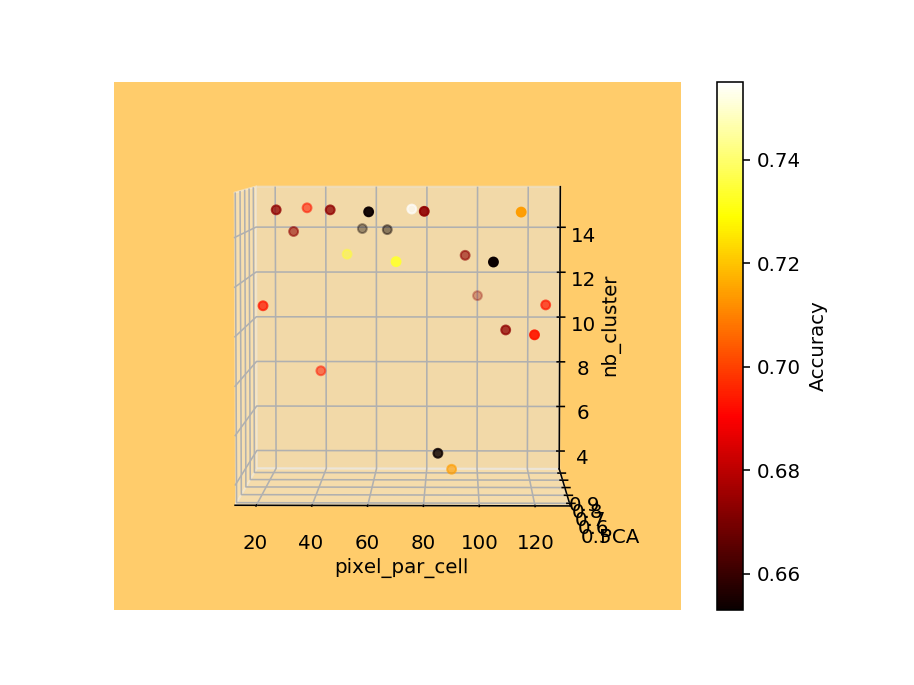

In [5]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot=ax.scatter(np.arange(20,130,5)
                , [op_p1[i]["num_pca"]for i in range (len(op_p1)) ]
                , [op_p1[i]["num_cluster"]for i in range (len(op_p1)) ],
                c=op_v1, cmap=plt.hot())
ax.set_xlabel('pixel_par_cell')
ax.set_ylabel('PCA')
ax.set_zlabel('nb_cluster')
ax.set_facecolor((1.0, 0.8, 0.42))
fig.colorbar(plot,label="Accuracy")
plt.show()

In [6]:
op_v2=[]
op_p2=[]
for i in range(len(hp2)):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial:objective(trial,i,hp2), n_trials=100)
    op_v2.append(study.best_value)
    op_p2.append(study.best_params)

[I 2020-03-23 01:58:55,669] Finished trial#0 resulted in value: 0.6938775510204082. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.89, 'num_cluster': 13}.
[I 2020-03-23 01:58:56,186] Finished trial#1 resulted in value: 0.6938775510204082. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.89, 'num_cluster': 13}.
[I 2020-03-23 01:58:56,709] Finished trial#2 resulted in value: 0.6938775510204082. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.89, 'num_cluster': 13}.
[I 2020-03-23 01:58:57,196] Finished trial#3 resulted in value: 0.40816326530612246. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.89, 'num_cluster': 13}.
[I 2020-03-23 01:58:57,710] Finished trial#4 resulted in value: 0.6122448979591837. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.89, 'num_cluster': 13}.
[I 2020-03-23 01:58:58,207] Finished trial#5 resulted in value: 0.6122448979591837. Current best va

[I 2020-03-23 01:59:41,645] Finished trial#90 resulted in value: 0.7755102040816326. Current best value is 0.7959183673469388 with parameters: {'num_pca': 0.9, 'num_cluster': 12}.
[I 2020-03-23 01:59:42,148] Finished trial#91 resulted in value: 0.7755102040816326. Current best value is 0.7959183673469388 with parameters: {'num_pca': 0.9, 'num_cluster': 12}.
[I 2020-03-23 01:59:42,740] Finished trial#92 resulted in value: 0.6938775510204082. Current best value is 0.7959183673469388 with parameters: {'num_pca': 0.9, 'num_cluster': 12}.
[I 2020-03-23 01:59:43,247] Finished trial#93 resulted in value: 0.5510204081632653. Current best value is 0.7959183673469388 with parameters: {'num_pca': 0.9, 'num_cluster': 12}.
[I 2020-03-23 01:59:43,752] Finished trial#94 resulted in value: 0.7755102040816326. Current best value is 0.7959183673469388 with parameters: {'num_pca': 0.9, 'num_cluster': 12}.
[I 2020-03-23 01:59:44,257] Finished trial#95 resulted in value: 0.7755102040816326. Current best va

[I 2020-03-23 02:00:10,941] Finished trial#79 resulted in value: 0.673469387755102. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.78, 'num_cluster': 11}.
[I 2020-03-23 02:00:11,259] Finished trial#80 resulted in value: 0.7346938775510204. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.78, 'num_cluster': 11}.
[I 2020-03-23 02:00:11,574] Finished trial#81 resulted in value: 0.7346938775510204. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.78, 'num_cluster': 11}.
[I 2020-03-23 02:00:11,886] Finished trial#82 resulted in value: 0.6530612244897959. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.78, 'num_cluster': 11}.
[I 2020-03-23 02:00:12,206] Finished trial#83 resulted in value: 0.6122448979591837. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.78, 'num_cluster': 11}.
[I 2020-03-23 02:00:12,522] Finished trial#84 resulted in value: 0.6122448979591837. Current bes

[I 2020-03-23 02:00:34,350] Finished trial#69 resulted in value: 0.5714285714285714. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.98, 'num_cluster': 14}.
[I 2020-03-23 02:00:34,603] Finished trial#70 resulted in value: 0.6938775510204082. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.98, 'num_cluster': 14}.
[I 2020-03-23 02:00:34,865] Finished trial#71 resulted in value: 0.5918367346938775. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.98, 'num_cluster': 14}.
[I 2020-03-23 02:00:35,106] Finished trial#72 resulted in value: 0.6938775510204082. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.98, 'num_cluster': 14}.
[I 2020-03-23 02:00:35,356] Finished trial#73 resulted in value: 0.7142857142857143. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.98, 'num_cluster': 14}.
[I 2020-03-23 02:00:35,612] Finished trial#74 resulted in value: 0.7142857142857143. Current be

[I 2020-03-23 02:00:53,921] Finished trial#59 resulted in value: 0.7755102040816326. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.72, 'num_cluster': 8}.
[I 2020-03-23 02:00:54,204] Finished trial#60 resulted in value: 0.6122448979591837. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.72, 'num_cluster': 8}.
[I 2020-03-23 02:00:54,478] Finished trial#61 resulted in value: 0.7551020408163265. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.72, 'num_cluster': 8}.
[I 2020-03-23 02:00:54,658] Finished trial#62 resulted in value: 0.6122448979591837. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.72, 'num_cluster': 8}.
[I 2020-03-23 02:00:54,911] Finished trial#63 resulted in value: 0.7551020408163265. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.72, 'num_cluster': 8}.
[I 2020-03-23 02:00:55,208] Finished trial#64 resulted in value: 0.673469387755102. Current best val

[I 2020-03-23 02:01:11,220] Finished trial#46 resulted in value: 0.673469387755102. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.5700000000000001, 'num_cluster': 14}.
[I 2020-03-23 02:01:11,406] Finished trial#47 resulted in value: 0.6530612244897959. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.5700000000000001, 'num_cluster': 14}.
[I 2020-03-23 02:01:11,581] Finished trial#48 resulted in value: 0.6326530612244898. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.5700000000000001, 'num_cluster': 14}.
[I 2020-03-23 02:01:11,747] Finished trial#49 resulted in value: 0.6530612244897959. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.5700000000000001, 'num_cluster': 14}.
[I 2020-03-23 02:01:11,933] Finished trial#50 resulted in value: 0.6122448979591837. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.5700000000000001, 'num_cluster': 14}.
[I 2020-03-23 02:01:12,114

[I 2020-03-23 02:01:25,345] Finished trial#32 resulted in value: 0.6326530612244898. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.62, 'num_cluster': 6}.
[I 2020-03-23 02:01:25,513] Finished trial#33 resulted in value: 0.673469387755102. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.62, 'num_cluster': 6}.
[I 2020-03-23 02:01:25,674] Finished trial#34 resulted in value: 0.5918367346938775. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.62, 'num_cluster': 6}.
[I 2020-03-23 02:01:25,819] Finished trial#35 resulted in value: 0.5510204081632653. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.62, 'num_cluster': 6}.
[I 2020-03-23 02:01:25,947] Finished trial#36 resulted in value: 0.42857142857142855. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.62, 'num_cluster': 6}.
[I 2020-03-23 02:01:26,084] Finished trial#37 resulted in value: 0.673469387755102. Current best val

[I 2020-03-23 02:01:38,721] Finished trial#21 resulted in value: 0.6938775510204082. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.67, 'num_cluster': 12}.
[I 2020-03-23 02:01:38,879] Finished trial#22 resulted in value: 0.6530612244897959. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.67, 'num_cluster': 12}.
[I 2020-03-23 02:01:39,035] Finished trial#23 resulted in value: 0.6530612244897959. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.67, 'num_cluster': 12}.
[I 2020-03-23 02:01:39,184] Finished trial#24 resulted in value: 0.6530612244897959. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.67, 'num_cluster': 12}.
[I 2020-03-23 02:01:39,339] Finished trial#25 resulted in value: 0.5918367346938775. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.67, 'num_cluster': 12}.
[I 2020-03-23 02:01:39,489] Finished trial#26 resulted in value: 0.6122448979591837. Current be

[I 2020-03-23 02:01:53,173] Finished trial#11 resulted in value: 0.5714285714285714. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.53, 'num_cluster': 13}.
[I 2020-03-23 02:01:53,333] Finished trial#12 resulted in value: 0.5714285714285714. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.53, 'num_cluster': 13}.
[I 2020-03-23 02:01:53,444] Finished trial#13 resulted in value: 0.40816326530612246. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.53, 'num_cluster': 13}.
[I 2020-03-23 02:01:53,564] Finished trial#14 resulted in value: 0.5918367346938775. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.53, 'num_cluster': 13}.
[I 2020-03-23 02:01:53,709] Finished trial#15 resulted in value: 0.6122448979591837. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.53, 'num_cluster': 13}.
[I 2020-03-23 02:01:53,844] Finished trial#16 resulted in value: 0.6530612244897959. Current b

[I 2020-03-23 02:02:06,259] Finished trial#1 resulted in value: 0.6326530612244898. Current best value is 0.6326530612244898 with parameters: {'num_pca': 0.52, 'num_cluster': 11}.
[I 2020-03-23 02:02:06,394] Finished trial#2 resulted in value: 0.5714285714285714. Current best value is 0.6326530612244898 with parameters: {'num_pca': 0.52, 'num_cluster': 11}.
[I 2020-03-23 02:02:06,514] Finished trial#3 resulted in value: 0.5918367346938775. Current best value is 0.6326530612244898 with parameters: {'num_pca': 0.52, 'num_cluster': 11}.
[I 2020-03-23 02:02:06,652] Finished trial#4 resulted in value: 0.7551020408163265. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.86, 'num_cluster': 13}.
[I 2020-03-23 02:02:06,791] Finished trial#5 resulted in value: 0.5714285714285714. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.86, 'num_cluster': 13}.
[I 2020-03-23 02:02:06,918] Finished trial#6 resulted in value: 0.5714285714285714. Current best val

[I 2020-03-23 02:02:19,020] Finished trial#91 resulted in value: 0.7346938775510204. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.67, 'num_cluster': 14}.
[I 2020-03-23 02:02:19,193] Finished trial#92 resulted in value: 0.7142857142857143. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.67, 'num_cluster': 14}.
[I 2020-03-23 02:02:19,347] Finished trial#93 resulted in value: 0.673469387755102. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.67, 'num_cluster': 14}.
[I 2020-03-23 02:02:19,496] Finished trial#94 resulted in value: 0.7346938775510204. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.67, 'num_cluster': 14}.
[I 2020-03-23 02:02:19,642] Finished trial#95 resulted in value: 0.6326530612244898. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.67, 'num_cluster': 14}.
[I 2020-03-23 02:02:19,797] Finished trial#96 resulted in value: 0.7346938775510204. Current bes

[I 2020-03-23 02:02:31,764] Finished trial#80 resulted in value: 0.7346938775510204. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.77, 'num_cluster': 14}.
[I 2020-03-23 02:02:31,906] Finished trial#81 resulted in value: 0.7346938775510204. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.77, 'num_cluster': 14}.
[I 2020-03-23 02:02:32,052] Finished trial#82 resulted in value: 0.7346938775510204. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.77, 'num_cluster': 14}.
[I 2020-03-23 02:02:32,194] Finished trial#83 resulted in value: 0.7346938775510204. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.77, 'num_cluster': 14}.
[I 2020-03-23 02:02:32,339] Finished trial#84 resulted in value: 0.6122448979591837. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.77, 'num_cluster': 14}.
[I 2020-03-23 02:02:32,482] Finished trial#85 resulted in value: 0.5510204081632653. Current be

[I 2020-03-23 02:02:44,148] Finished trial#70 resulted in value: 0.673469387755102. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.71, 'num_cluster': 12}.
[I 2020-03-23 02:02:44,291] Finished trial#71 resulted in value: 0.5918367346938775. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.71, 'num_cluster': 12}.
[I 2020-03-23 02:02:44,439] Finished trial#72 resulted in value: 0.6530612244897959. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.71, 'num_cluster': 12}.
[I 2020-03-23 02:02:44,583] Finished trial#73 resulted in value: 0.673469387755102. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.71, 'num_cluster': 12}.
[I 2020-03-23 02:02:44,731] Finished trial#74 resulted in value: 0.5714285714285714. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.71, 'num_cluster': 12}.
[I 2020-03-23 02:02:44,867] Finished trial#75 resulted in value: 0.5306122448979592. Current best

[I 2020-03-23 02:02:55,816] Finished trial#60 resulted in value: 0.673469387755102. Current best value is 0.7959183673469388 with parameters: {'num_pca': 0.78, 'num_cluster': 8}.
[I 2020-03-23 02:02:55,939] Finished trial#61 resulted in value: 0.6326530612244898. Current best value is 0.7959183673469388 with parameters: {'num_pca': 0.78, 'num_cluster': 8}.
[I 2020-03-23 02:02:56,067] Finished trial#62 resulted in value: 0.6530612244897959. Current best value is 0.7959183673469388 with parameters: {'num_pca': 0.78, 'num_cluster': 8}.
[I 2020-03-23 02:02:56,197] Finished trial#63 resulted in value: 0.7959183673469388. Current best value is 0.7959183673469388 with parameters: {'num_pca': 0.78, 'num_cluster': 8}.
[I 2020-03-23 02:02:56,321] Finished trial#64 resulted in value: 0.7959183673469388. Current best value is 0.7959183673469388 with parameters: {'num_pca': 0.78, 'num_cluster': 8}.
[I 2020-03-23 02:02:56,444] Finished trial#65 resulted in value: 0.7959183673469388. Current best val

[I 2020-03-23 02:03:07,039] Finished trial#49 resulted in value: 0.6530612244897959. Current best value is 0.8163265306122449 with parameters: {'num_pca': 0.53, 'num_cluster': 10}.
[I 2020-03-23 02:03:07,174] Finished trial#50 resulted in value: 0.7142857142857143. Current best value is 0.8163265306122449 with parameters: {'num_pca': 0.53, 'num_cluster': 10}.
[I 2020-03-23 02:03:07,333] Finished trial#51 resulted in value: 0.8163265306122449. Current best value is 0.8163265306122449 with parameters: {'num_pca': 0.53, 'num_cluster': 10}.
[I 2020-03-23 02:03:07,456] Finished trial#52 resulted in value: 0.7346938775510204. Current best value is 0.8163265306122449 with parameters: {'num_pca': 0.53, 'num_cluster': 10}.
[I 2020-03-23 02:03:07,587] Finished trial#53 resulted in value: 0.7755102040816326. Current best value is 0.8163265306122449 with parameters: {'num_pca': 0.53, 'num_cluster': 10}.
[I 2020-03-23 02:03:07,708] Finished trial#54 resulted in value: 0.6530612244897959. Current be

[I 2020-03-23 02:03:18,636] Finished trial#39 resulted in value: 0.6122448979591837. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.86, 'num_cluster': 8}.
[I 2020-03-23 02:03:18,783] Finished trial#40 resulted in value: 0.6938775510204082. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.86, 'num_cluster': 8}.
[I 2020-03-23 02:03:18,916] Finished trial#41 resulted in value: 0.7142857142857143. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.86, 'num_cluster': 8}.
[I 2020-03-23 02:03:19,052] Finished trial#42 resulted in value: 0.6530612244897959. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.86, 'num_cluster': 8}.
[I 2020-03-23 02:03:19,184] Finished trial#43 resulted in value: 0.6122448979591837. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.86, 'num_cluster': 8}.
[I 2020-03-23 02:03:19,313] Finished trial#44 resulted in value: 0.6122448979591837. Current best va

[I 2020-03-23 02:03:30,042] Finished trial#29 resulted in value: 0.4897959183673469. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.62, 'num_cluster': 13}.
[I 2020-03-23 02:03:30,173] Finished trial#30 resulted in value: 0.5714285714285714. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.62, 'num_cluster': 13}.
[I 2020-03-23 02:03:30,290] Finished trial#31 resulted in value: 0.5306122448979592. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.62, 'num_cluster': 13}.
[I 2020-03-23 02:03:30,401] Finished trial#32 resulted in value: 0.3877551020408163. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.62, 'num_cluster': 13}.
[I 2020-03-23 02:03:30,524] Finished trial#33 resulted in value: 0.5918367346938775. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.62, 'num_cluster': 13}.
[I 2020-03-23 02:03:30,641] Finished trial#34 resulted in value: 0.673469387755102. Current bes

[I 2020-03-23 02:03:41,803] Finished trial#19 resulted in value: 0.5510204081632653. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.76, 'num_cluster': 13}.
[I 2020-03-23 02:03:41,986] Finished trial#20 resulted in value: 0.6326530612244898. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.76, 'num_cluster': 13}.
[I 2020-03-23 02:03:42,167] Finished trial#21 resulted in value: 0.7346938775510204. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.76, 'num_cluster': 13}.
[I 2020-03-23 02:03:42,308] Finished trial#22 resulted in value: 0.7346938775510204. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.76, 'num_cluster': 13}.
[I 2020-03-23 02:03:42,445] Finished trial#23 resulted in value: 0.5918367346938775. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.76, 'num_cluster': 13}.
[I 2020-03-23 02:03:42,581] Finished trial#24 resulted in value: 0.6122448979591837. Current be

[I 2020-03-23 02:03:54,152] Finished trial#9 resulted in value: 0.3877551020408163. Current best value is 0.673469387755102 with parameters: {'num_pca': 0.53, 'num_cluster': 10}.
[I 2020-03-23 02:03:54,280] Finished trial#10 resulted in value: 0.5714285714285714. Current best value is 0.673469387755102 with parameters: {'num_pca': 0.53, 'num_cluster': 10}.
[I 2020-03-23 02:03:54,416] Finished trial#11 resulted in value: 0.5714285714285714. Current best value is 0.673469387755102 with parameters: {'num_pca': 0.53, 'num_cluster': 10}.
[I 2020-03-23 02:03:54,564] Finished trial#12 resulted in value: 0.5510204081632653. Current best value is 0.673469387755102 with parameters: {'num_pca': 0.53, 'num_cluster': 10}.
[I 2020-03-23 02:03:54,695] Finished trial#13 resulted in value: 0.6530612244897959. Current best value is 0.673469387755102 with parameters: {'num_pca': 0.53, 'num_cluster': 10}.
[I 2020-03-23 02:03:54,816] Finished trial#14 resulted in value: 0.5510204081632653. Current best val

[I 2020-03-23 02:04:06,249] Finished trial#99 resulted in value: 0.6938775510204082. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.88, 'num_cluster': 14}.
[I 2020-03-23 02:04:06,361] Finished trial#0 resulted in value: 0.5714285714285714. Current best value is 0.5714285714285714 with parameters: {'num_pca': 0.95, 'num_cluster': 7}.
[I 2020-03-23 02:04:06,479] Finished trial#1 resulted in value: 0.6530612244897959. Current best value is 0.6530612244897959 with parameters: {'num_pca': 0.8200000000000001, 'num_cluster': 12}.
[I 2020-03-23 02:04:06,581] Finished trial#2 resulted in value: 0.46938775510204084. Current best value is 0.6530612244897959 with parameters: {'num_pca': 0.8200000000000001, 'num_cluster': 12}.
[I 2020-03-23 02:04:06,702] Finished trial#3 resulted in value: 0.5918367346938775. Current best value is 0.6530612244897959 with parameters: {'num_pca': 0.8200000000000001, 'num_cluster': 12}.
[I 2020-03-23 02:04:06,830] Finished trial#4 resulted in 

[I 2020-03-23 02:04:18,146] Finished trial#88 resulted in value: 0.5306122448979592. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.97, 'num_cluster': 15}.
[I 2020-03-23 02:04:18,284] Finished trial#89 resulted in value: 0.7142857142857143. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.97, 'num_cluster': 15}.
[I 2020-03-23 02:04:18,415] Finished trial#90 resulted in value: 0.5918367346938775. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.97, 'num_cluster': 15}.
[I 2020-03-23 02:04:18,552] Finished trial#91 resulted in value: 0.6326530612244898. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.97, 'num_cluster': 15}.
[I 2020-03-23 02:04:18,697] Finished trial#92 resulted in value: 0.7142857142857143. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.97, 'num_cluster': 15}.
[I 2020-03-23 02:04:18,830] Finished trial#93 resulted in value: 0.5306122448979592. Current be

[I 2020-03-23 02:04:28,425] Finished trial#78 resulted in value: 0.6938775510204082. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.54, 'num_cluster': 4}.
[I 2020-03-23 02:04:28,568] Finished trial#79 resulted in value: 0.6326530612244898. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.54, 'num_cluster': 4}.
[I 2020-03-23 02:04:28,676] Finished trial#80 resulted in value: 0.5102040816326531. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.54, 'num_cluster': 4}.
[I 2020-03-23 02:04:28,784] Finished trial#81 resulted in value: 0.673469387755102. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.54, 'num_cluster': 4}.
[I 2020-03-23 02:04:28,895] Finished trial#82 resulted in value: 0.6938775510204082. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.54, 'num_cluster': 4}.
[I 2020-03-23 02:04:29,003] Finished trial#83 resulted in value: 0.673469387755102. Current best valu

[I 2020-03-23 02:04:38,612] Finished trial#64 resulted in value: 0.5510204081632653. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.8500000000000001, 'num_cluster': 11}.
[I 2020-03-23 02:04:38,776] Finished trial#65 resulted in value: 0.6938775510204082. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.8500000000000001, 'num_cluster': 11}.
[I 2020-03-23 02:04:38,924] Finished trial#66 resulted in value: 0.6122448979591837. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.8500000000000001, 'num_cluster': 11}.
[I 2020-03-23 02:04:39,077] Finished trial#67 resulted in value: 0.5714285714285714. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.8500000000000001, 'num_cluster': 11}.
[I 2020-03-23 02:04:39,223] Finished trial#68 resulted in value: 0.6326530612244898. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.8500000000000001, 'num_cluster': 11}.
[I 2020-03-23 02:04:39,35

[I 2020-03-23 02:04:49,883] Finished trial#51 resulted in value: 0.6530612244897959. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.91, 'num_cluster': 10}.
[I 2020-03-23 02:04:50,009] Finished trial#52 resulted in value: 0.6530612244897959. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.91, 'num_cluster': 10}.
[I 2020-03-23 02:04:50,136] Finished trial#53 resulted in value: 0.6530612244897959. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.91, 'num_cluster': 10}.
[I 2020-03-23 02:04:50,264] Finished trial#54 resulted in value: 0.6326530612244898. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.91, 'num_cluster': 10}.
[I 2020-03-23 02:04:50,386] Finished trial#55 resulted in value: 0.6326530612244898. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.91, 'num_cluster': 10}.
[I 2020-03-23 02:04:50,501] Finished trial#56 resulted in value: 0.6122448979591837. Current be

[I 2020-03-23 02:05:01,225] Finished trial#40 resulted in value: 0.673469387755102. Current best value is 0.673469387755102 with parameters: {'num_pca': 0.88, 'num_cluster': 11}.
[I 2020-03-23 02:05:01,359] Finished trial#41 resulted in value: 0.6938775510204082. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.62, 'num_cluster': 14}.
[I 2020-03-23 02:05:01,502] Finished trial#42 resulted in value: 0.6530612244897959. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.62, 'num_cluster': 14}.
[I 2020-03-23 02:05:01,646] Finished trial#43 resulted in value: 0.6326530612244898. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.62, 'num_cluster': 14}.
[I 2020-03-23 02:05:01,787] Finished trial#44 resulted in value: 0.6530612244897959. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.62, 'num_cluster': 14}.
[I 2020-03-23 02:05:01,921] Finished trial#45 resulted in value: 0.6326530612244898. Current best

<IPython.core.display.Javascript object>


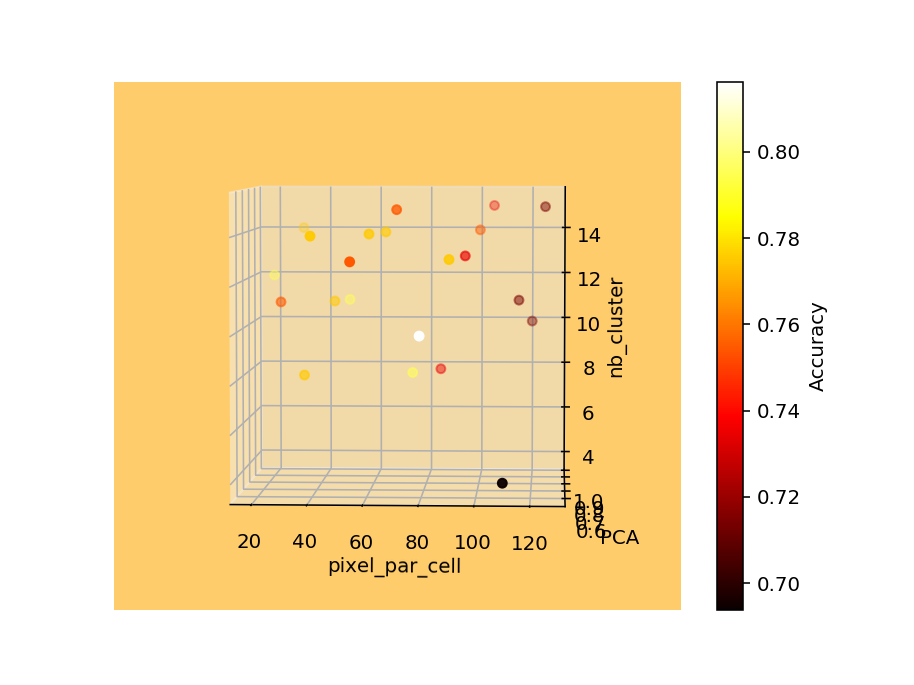

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot=ax.scatter(np.arange(20,130,5)
                , [op_p2[i]["num_pca"]for i in range (len(op_p2)) ]
                , [op_p2[i]["num_cluster"]for i in range (len(op_p2)) ],
                c=op_v2, cmap=plt.hot())
ax.set_xlabel('pixel_par_cell')
ax.set_ylabel('PCA')
ax.set_zlabel('nb_cluster')
ax.set_facecolor((1.0, 0.8, 0.42))
fig.colorbar(plot,label="Accuracy")
plt.show()

In [8]:
op_v3=[]
op_p3=[]
for i in range(len(hp3)):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial:objective(trial,i,hp3), n_trials=100)
    op_v3.append(study.best_value)
    op_p3.append(study.best_params)

[I 2020-03-23 02:05:13,075] Finished trial#0 resulted in value: 0.6326530612244898. Current best value is 0.6326530612244898 with parameters: {'num_pca': 0.77, 'num_cluster': 11}.
[I 2020-03-23 02:05:15,135] Finished trial#1 resulted in value: 0.5918367346938775. Current best value is 0.6326530612244898 with parameters: {'num_pca': 0.77, 'num_cluster': 11}.
[I 2020-03-23 02:05:17,113] Finished trial#2 resulted in value: 0.6938775510204082. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.5, 'num_cluster': 14}.
[I 2020-03-23 02:05:18,921] Finished trial#3 resulted in value: 0.7551020408163265. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.65, 'num_cluster': 15}.
[I 2020-03-23 02:05:19,999] Finished trial#4 resulted in value: 0.6530612244897959. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.65, 'num_cluster': 15}.
[I 2020-03-23 02:05:21,030] Finished trial#5 resulted in value: 0.7346938775510204. Current best valu

[I 2020-03-23 02:06:48,431] Finished trial#90 resulted in value: 0.6122448979591837. Current best value is 0.7959183673469388 with parameters: {'num_pca': 0.51, 'num_cluster': 15}.
[I 2020-03-23 02:06:49,451] Finished trial#91 resulted in value: 0.6326530612244898. Current best value is 0.7959183673469388 with parameters: {'num_pca': 0.51, 'num_cluster': 15}.
[I 2020-03-23 02:06:50,485] Finished trial#92 resulted in value: 0.6530612244897959. Current best value is 0.7959183673469388 with parameters: {'num_pca': 0.51, 'num_cluster': 15}.
[I 2020-03-23 02:06:51,517] Finished trial#93 resulted in value: 0.673469387755102. Current best value is 0.7959183673469388 with parameters: {'num_pca': 0.51, 'num_cluster': 15}.
[I 2020-03-23 02:06:52,534] Finished trial#94 resulted in value: 0.7551020408163265. Current best value is 0.7959183673469388 with parameters: {'num_pca': 0.51, 'num_cluster': 15}.
[I 2020-03-23 02:06:53,600] Finished trial#95 resulted in value: 0.7551020408163265. Current bes

[I 2020-03-23 02:07:47,757] Finished trial#79 resulted in value: 0.7346938775510204. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.58, 'num_cluster': 13}.
[I 2020-03-23 02:07:48,397] Finished trial#80 resulted in value: 0.6938775510204082. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.58, 'num_cluster': 13}.
[I 2020-03-23 02:07:49,034] Finished trial#81 resulted in value: 0.6122448979591837. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.58, 'num_cluster': 13}.
[I 2020-03-23 02:07:49,677] Finished trial#82 resulted in value: 0.673469387755102. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.58, 'num_cluster': 13}.
[I 2020-03-23 02:07:50,316] Finished trial#83 resulted in value: 0.7142857142857143. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.58, 'num_cluster': 13}.
[I 2020-03-23 02:07:50,959] Finished trial#84 resulted in value: 0.6938775510204082. Current bes

[I 2020-03-23 02:08:32,372] Finished trial#67 resulted in value: 0.6326530612244898. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.5, 'num_cluster': 13}.
[I 2020-03-23 02:08:32,844] Finished trial#68 resulted in value: 0.7142857142857143. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.5, 'num_cluster': 13}.
[I 2020-03-23 02:08:33,316] Finished trial#69 resulted in value: 0.5918367346938775. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.5, 'num_cluster': 13}.
[I 2020-03-23 02:08:33,791] Finished trial#70 resulted in value: 0.6530612244897959. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.5, 'num_cluster': 13}.
[I 2020-03-23 02:08:34,262] Finished trial#71 resulted in value: 0.7346938775510204. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.5, 'num_cluster': 13}.
[I 2020-03-23 02:08:34,734] Finished trial#72 resulted in value: 0.7346938775510204. Current best va

[I 2020-03-23 02:09:04,671] Finished trial#57 resulted in value: 0.7551020408163265. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.89, 'num_cluster': 11}.
[I 2020-03-23 02:09:04,973] Finished trial#58 resulted in value: 0.673469387755102. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.89, 'num_cluster': 11}.
[I 2020-03-23 02:09:05,267] Finished trial#59 resulted in value: 0.673469387755102. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.89, 'num_cluster': 11}.
[I 2020-03-23 02:09:05,563] Finished trial#60 resulted in value: 0.6938775510204082. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.89, 'num_cluster': 11}.
[I 2020-03-23 02:09:05,863] Finished trial#61 resulted in value: 0.7755102040816326. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.89, 'num_cluster': 11}.
[I 2020-03-23 02:09:06,142] Finished trial#62 resulted in value: 0.46938775510204084. Current bes

[I 2020-03-23 02:09:27,424] Finished trial#45 resulted in value: 0.6530612244897959. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.98, 'num_cluster': 9}.
[I 2020-03-23 02:09:27,659] Finished trial#46 resulted in value: 0.6938775510204082. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.98, 'num_cluster': 9}.
[I 2020-03-23 02:09:27,893] Finished trial#47 resulted in value: 0.5918367346938775. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.98, 'num_cluster': 9}.
[I 2020-03-23 02:09:28,128] Finished trial#48 resulted in value: 0.6938775510204082. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.98, 'num_cluster': 9}.
[I 2020-03-23 02:09:28,347] Finished trial#49 resulted in value: 0.6326530612244898. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.98, 'num_cluster': 9}.
[I 2020-03-23 02:09:28,567] Finished trial#50 resulted in value: 0.5714285714285714. Current best va

[I 2020-03-23 02:09:46,552] Finished trial#35 resulted in value: 0.5918367346938775. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.95, 'num_cluster': 10}.
[I 2020-03-23 02:09:46,752] Finished trial#36 resulted in value: 0.673469387755102. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.95, 'num_cluster': 10}.
[I 2020-03-23 02:09:46,935] Finished trial#37 resulted in value: 0.6530612244897959. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.95, 'num_cluster': 10}.
[I 2020-03-23 02:09:47,136] Finished trial#38 resulted in value: 0.7755102040816326. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.74, 'num_cluster': 14}.
[I 2020-03-23 02:09:47,333] Finished trial#39 resulted in value: 0.7346938775510204. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.74, 'num_cluster': 14}.
[I 2020-03-23 02:09:47,531] Finished trial#40 resulted in value: 0.7346938775510204. Current bes

[I 2020-03-23 02:10:04,599] Finished trial#25 resulted in value: 0.6122448979591837. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.74, 'num_cluster': 12}.
[I 2020-03-23 02:10:04,789] Finished trial#26 resulted in value: 0.6938775510204082. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.74, 'num_cluster': 12}.
[I 2020-03-23 02:10:04,976] Finished trial#27 resulted in value: 0.6530612244897959. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.74, 'num_cluster': 12}.
[I 2020-03-23 02:10:05,174] Finished trial#28 resulted in value: 0.6326530612244898. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.74, 'num_cluster': 12}.
[I 2020-03-23 02:10:05,364] Finished trial#29 resulted in value: 0.6938775510204082. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.74, 'num_cluster': 12}.
[I 2020-03-23 02:10:05,544] Finished trial#30 resulted in value: 0.5510204081632653. Current be

[I 2020-03-23 02:10:21,903] Finished trial#14 resulted in value: 0.5918367346938775. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.65, 'num_cluster': 15}.
[I 2020-03-23 02:10:22,058] Finished trial#15 resulted in value: 0.6122448979591837. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.65, 'num_cluster': 15}.
[I 2020-03-23 02:10:22,209] Finished trial#16 resulted in value: 0.6326530612244898. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.65, 'num_cluster': 15}.
[I 2020-03-23 02:10:22,370] Finished trial#17 resulted in value: 0.7142857142857143. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.65, 'num_cluster': 15}.
[I 2020-03-23 02:10:22,528] Finished trial#18 resulted in value: 0.6938775510204082. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.65, 'num_cluster': 15}.
[I 2020-03-23 02:10:22,702] Finished trial#19 resulted in value: 0.7755102040816326. Current be

[I 2020-03-23 02:10:37,028] Finished trial#4 resulted in value: 0.673469387755102. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.54, 'num_cluster': 15}.
[I 2020-03-23 02:10:37,167] Finished trial#5 resulted in value: 0.7142857142857143. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.54, 'num_cluster': 15}.
[I 2020-03-23 02:10:37,338] Finished trial#6 resulted in value: 0.673469387755102. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.54, 'num_cluster': 15}.
[I 2020-03-23 02:10:37,472] Finished trial#7 resulted in value: 0.6122448979591837. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.54, 'num_cluster': 15}.
[I 2020-03-23 02:10:37,623] Finished trial#8 resulted in value: 0.6326530612244898. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.54, 'num_cluster': 15}.
[I 2020-03-23 02:10:37,774] Finished trial#9 resulted in value: 0.6530612244897959. Current best value

[I 2020-03-23 02:10:50,319] Finished trial#94 resulted in value: 0.7142857142857143. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.73, 'num_cluster': 9}.
[I 2020-03-23 02:10:50,486] Finished trial#95 resulted in value: 0.6122448979591837. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.73, 'num_cluster': 9}.
[I 2020-03-23 02:10:50,626] Finished trial#96 resulted in value: 0.42857142857142855. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.73, 'num_cluster': 9}.
[I 2020-03-23 02:10:50,767] Finished trial#97 resulted in value: 0.5918367346938775. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.73, 'num_cluster': 9}.
[I 2020-03-23 02:10:50,912] Finished trial#98 resulted in value: 0.6122448979591837. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.73, 'num_cluster': 9}.
[I 2020-03-23 02:10:51,047] Finished trial#99 resulted in value: 0.40816326530612246. Current best 

[I 2020-03-23 02:11:04,120] Finished trial#84 resulted in value: 0.7142857142857143. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.66, 'num_cluster': 13}.
[I 2020-03-23 02:11:04,284] Finished trial#85 resulted in value: 0.673469387755102. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.66, 'num_cluster': 13}.
[I 2020-03-23 02:11:04,433] Finished trial#86 resulted in value: 0.6326530612244898. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.66, 'num_cluster': 13}.
[I 2020-03-23 02:11:04,583] Finished trial#87 resulted in value: 0.5714285714285714. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.66, 'num_cluster': 13}.
[I 2020-03-23 02:11:04,736] Finished trial#88 resulted in value: 0.6122448979591837. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.66, 'num_cluster': 13}.
[I 2020-03-23 02:11:04,881] Finished trial#89 resulted in value: 0.6122448979591837. Current bes

[I 2020-03-23 02:11:16,897] Finished trial#69 resulted in value: 0.7346938775510204. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.8500000000000001, 'num_cluster': 13}.
[I 2020-03-23 02:11:17,053] Finished trial#70 resulted in value: 0.7346938775510204. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.8500000000000001, 'num_cluster': 13}.
[I 2020-03-23 02:11:17,208] Finished trial#71 resulted in value: 0.6122448979591837. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.8500000000000001, 'num_cluster': 13}.
[I 2020-03-23 02:11:17,364] Finished trial#72 resulted in value: 0.7755102040816326. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.8400000000000001, 'num_cluster': 14}.
[I 2020-03-23 02:11:17,517] Finished trial#73 resulted in value: 0.7755102040816326. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.8400000000000001, 'num_cluster': 14}.
[I 2020-03-23 02:11:17,67

[I 2020-03-23 02:11:29,338] Finished trial#56 resulted in value: 0.6938775510204082. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.73, 'num_cluster': 5}.
[I 2020-03-23 02:11:29,465] Finished trial#57 resulted in value: 0.6530612244897959. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.73, 'num_cluster': 5}.
[I 2020-03-23 02:11:29,592] Finished trial#58 resulted in value: 0.673469387755102. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.73, 'num_cluster': 5}.
[I 2020-03-23 02:11:29,730] Finished trial#59 resulted in value: 0.6938775510204082. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.73, 'num_cluster': 5}.
[I 2020-03-23 02:11:29,869] Finished trial#60 resulted in value: 0.5102040816326531. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.73, 'num_cluster': 5}.
[I 2020-03-23 02:11:30,005] Finished trial#61 resulted in value: 0.6326530612244898. Current best val

[I 2020-03-23 02:11:41,888] Finished trial#46 resulted in value: 0.6122448979591837. Current best value is 0.8367346938775511 with parameters: {'num_pca': 0.77, 'num_cluster': 8}.
[I 2020-03-23 02:11:42,029] Finished trial#47 resulted in value: 0.6122448979591837. Current best value is 0.8367346938775511 with parameters: {'num_pca': 0.77, 'num_cluster': 8}.
[I 2020-03-23 02:11:42,173] Finished trial#48 resulted in value: 0.673469387755102. Current best value is 0.8367346938775511 with parameters: {'num_pca': 0.77, 'num_cluster': 8}.
[I 2020-03-23 02:11:42,318] Finished trial#49 resulted in value: 0.5918367346938775. Current best value is 0.8367346938775511 with parameters: {'num_pca': 0.77, 'num_cluster': 8}.
[I 2020-03-23 02:11:42,467] Finished trial#50 resulted in value: 0.6530612244897959. Current best value is 0.8367346938775511 with parameters: {'num_pca': 0.77, 'num_cluster': 8}.
[I 2020-03-23 02:11:42,609] Finished trial#51 resulted in value: 0.5918367346938775. Current best val

[I 2020-03-23 02:11:54,355] Finished trial#36 resulted in value: 0.6530612244897959. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.73, 'num_cluster': 15}.
[I 2020-03-23 02:11:54,498] Finished trial#37 resulted in value: 0.5918367346938775. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.73, 'num_cluster': 15}.
[I 2020-03-23 02:11:54,626] Finished trial#38 resulted in value: 0.6122448979591837. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.73, 'num_cluster': 15}.
[I 2020-03-23 02:11:54,761] Finished trial#39 resulted in value: 0.6938775510204082. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.73, 'num_cluster': 15}.
[I 2020-03-23 02:11:54,900] Finished trial#40 resulted in value: 0.6530612244897959. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.73, 'num_cluster': 15}.
[I 2020-03-23 02:11:55,030] Finished trial#41 resulted in value: 0.5918367346938775. Current be

[I 2020-03-23 02:12:07,032] Finished trial#26 resulted in value: 0.6326530612244898. Current best value is 0.6326530612244898 with parameters: {'num_pca': 0.51, 'num_cluster': 12}.
[I 2020-03-23 02:12:07,201] Finished trial#27 resulted in value: 0.5714285714285714. Current best value is 0.6326530612244898 with parameters: {'num_pca': 0.51, 'num_cluster': 12}.
[I 2020-03-23 02:12:07,346] Finished trial#28 resulted in value: 0.5510204081632653. Current best value is 0.6326530612244898 with parameters: {'num_pca': 0.51, 'num_cluster': 12}.
[I 2020-03-23 02:12:07,487] Finished trial#29 resulted in value: 0.5306122448979592. Current best value is 0.6326530612244898 with parameters: {'num_pca': 0.51, 'num_cluster': 12}.
[I 2020-03-23 02:12:07,606] Finished trial#30 resulted in value: 0.5918367346938775. Current best value is 0.6326530612244898 with parameters: {'num_pca': 0.51, 'num_cluster': 12}.
[I 2020-03-23 02:12:07,740] Finished trial#31 resulted in value: 0.6122448979591837. Current be

[I 2020-03-23 02:12:20,136] Finished trial#16 resulted in value: 0.673469387755102. Current best value is 0.673469387755102 with parameters: {'num_pca': 0.72, 'num_cluster': 13}.
[I 2020-03-23 02:12:20,265] Finished trial#17 resulted in value: 0.5918367346938775. Current best value is 0.673469387755102 with parameters: {'num_pca': 0.72, 'num_cluster': 13}.
[I 2020-03-23 02:12:20,398] Finished trial#18 resulted in value: 0.673469387755102. Current best value is 0.673469387755102 with parameters: {'num_pca': 0.72, 'num_cluster': 13}.
[I 2020-03-23 02:12:20,526] Finished trial#19 resulted in value: 0.6530612244897959. Current best value is 0.673469387755102 with parameters: {'num_pca': 0.72, 'num_cluster': 13}.
[I 2020-03-23 02:12:20,670] Finished trial#20 resulted in value: 0.6122448979591837. Current best value is 0.673469387755102 with parameters: {'num_pca': 0.72, 'num_cluster': 13}.
[I 2020-03-23 02:12:20,808] Finished trial#21 resulted in value: 0.5714285714285714. Current best valu

[I 2020-03-23 02:12:32,797] Finished trial#6 resulted in value: 0.5714285714285714. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.76, 'num_cluster': 13}.
[I 2020-03-23 02:12:32,922] Finished trial#7 resulted in value: 0.6530612244897959. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.76, 'num_cluster': 13}.
[I 2020-03-23 02:12:33,058] Finished trial#8 resulted in value: 0.6326530612244898. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.76, 'num_cluster': 13}.
[I 2020-03-23 02:12:33,183] Finished trial#9 resulted in value: 0.6326530612244898. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.76, 'num_cluster': 13}.
[I 2020-03-23 02:12:33,315] Finished trial#10 resulted in value: 0.6122448979591837. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.76, 'num_cluster': 13}.
[I 2020-03-23 02:12:33,440] Finished trial#11 resulted in value: 0.6530612244897959. Current best v

[I 2020-03-23 02:12:44,590] Finished trial#90 resulted in value: 0.6938775510204082. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.8200000000000001, 'num_cluster': 13}.
[I 2020-03-23 02:12:44,739] Finished trial#91 resulted in value: 0.673469387755102. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.8200000000000001, 'num_cluster': 13}.
[I 2020-03-23 02:12:44,880] Finished trial#92 resulted in value: 0.6122448979591837. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.8200000000000001, 'num_cluster': 13}.
[I 2020-03-23 02:12:45,021] Finished trial#93 resulted in value: 0.6938775510204082. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.8200000000000001, 'num_cluster': 13}.
[I 2020-03-23 02:12:45,213] Finished trial#94 resulted in value: 0.5918367346938775. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.8200000000000001, 'num_cluster': 13}.
[I 2020-03-23 02:12:45,375

[I 2020-03-23 02:12:56,510] Finished trial#79 resulted in value: 0.5918367346938775. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.95, 'num_cluster': 13}.
[I 2020-03-23 02:12:56,647] Finished trial#80 resulted in value: 0.5714285714285714. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.95, 'num_cluster': 13}.
[I 2020-03-23 02:12:56,788] Finished trial#81 resulted in value: 0.6326530612244898. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.95, 'num_cluster': 13}.
[I 2020-03-23 02:12:56,927] Finished trial#82 resulted in value: 0.5510204081632653. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.95, 'num_cluster': 13}.
[I 2020-03-23 02:12:57,069] Finished trial#83 resulted in value: 0.5510204081632653. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.95, 'num_cluster': 13}.
[I 2020-03-23 02:12:57,203] Finished trial#84 resulted in value: 0.5918367346938775. Current be

[I 2020-03-23 02:13:07,766] Finished trial#65 resulted in value: 0.5918367346938775. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.8500000000000001, 'num_cluster': 15}.
[I 2020-03-23 02:13:07,907] Finished trial#66 resulted in value: 0.5918367346938775. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.8500000000000001, 'num_cluster': 15}.
[I 2020-03-23 02:13:08,046] Finished trial#67 resulted in value: 0.5306122448979592. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.8500000000000001, 'num_cluster': 15}.
[I 2020-03-23 02:13:08,178] Finished trial#68 resulted in value: 0.5918367346938775. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.8500000000000001, 'num_cluster': 15}.
[I 2020-03-23 02:13:08,331] Finished trial#69 resulted in value: 0.5714285714285714. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.8500000000000001, 'num_cluster': 15}.
[I 2020-03-23 02:13:08,47

[I 2020-03-23 02:13:19,369] Finished trial#52 resulted in value: 0.6122448979591837. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.59, 'num_cluster': 10}.
[I 2020-03-23 02:13:19,493] Finished trial#53 resulted in value: 0.5918367346938775. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.59, 'num_cluster': 10}.
[I 2020-03-23 02:13:19,611] Finished trial#54 resulted in value: 0.5714285714285714. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.59, 'num_cluster': 10}.
[I 2020-03-23 02:13:19,738] Finished trial#55 resulted in value: 0.5918367346938775. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.59, 'num_cluster': 10}.
[I 2020-03-23 02:13:19,878] Finished trial#56 resulted in value: 0.6326530612244898. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.59, 'num_cluster': 10}.
[I 2020-03-23 02:13:19,999] Finished trial#57 resulted in value: 0.5306122448979592. Current be

[I 2020-03-23 02:13:31,345] Finished trial#42 resulted in value: 0.5306122448979592. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.88, 'num_cluster': 13}.
[I 2020-03-23 02:13:31,476] Finished trial#43 resulted in value: 0.5918367346938775. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.88, 'num_cluster': 13}.
[I 2020-03-23 02:13:31,613] Finished trial#44 resulted in value: 0.6530612244897959. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.88, 'num_cluster': 13}.
[I 2020-03-23 02:13:31,742] Finished trial#45 resulted in value: 0.6938775510204082. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.88, 'num_cluster': 13}.
[I 2020-03-23 02:13:31,863] Finished trial#46 resulted in value: 0.5918367346938775. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.88, 'num_cluster': 13}.
[I 2020-03-23 02:13:31,998] Finished trial#47 resulted in value: 0.7346938775510204. Current be

[I 2020-03-23 02:13:43,391] Finished trial#31 resulted in value: 0.6530612244897959. Current best value is 0.7959183673469388 with parameters: {'num_pca': 0.99, 'num_cluster': 13}.
[I 2020-03-23 02:13:43,536] Finished trial#32 resulted in value: 0.6530612244897959. Current best value is 0.7959183673469388 with parameters: {'num_pca': 0.99, 'num_cluster': 13}.
[I 2020-03-23 02:13:43,684] Finished trial#33 resulted in value: 0.673469387755102. Current best value is 0.7959183673469388 with parameters: {'num_pca': 0.99, 'num_cluster': 13}.
[I 2020-03-23 02:13:43,827] Finished trial#34 resulted in value: 0.5918367346938775. Current best value is 0.7959183673469388 with parameters: {'num_pca': 0.99, 'num_cluster': 13}.
[I 2020-03-23 02:13:43,959] Finished trial#35 resulted in value: 0.6122448979591837. Current best value is 0.7959183673469388 with parameters: {'num_pca': 0.99, 'num_cluster': 13}.
[I 2020-03-23 02:13:44,093] Finished trial#36 resulted in value: 0.6122448979591837. Current bes

<IPython.core.display.Javascript object>


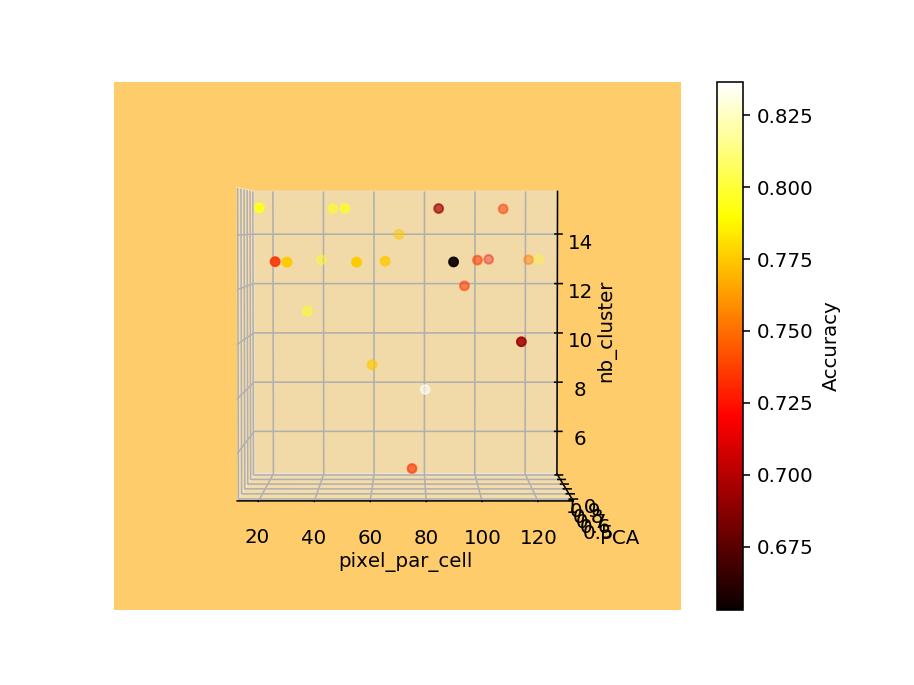

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot=ax.scatter(np.arange(20,130,5)
                , [op_p3[i]["num_pca"]for i in range (len(op_p3)) ]
                , [op_p3[i]["num_cluster"]for i in range (len(op_p3)) ],
                c=op_v3, cmap=plt.hot())
ax.set_xlabel('pixel_par_cell')
ax.set_ylabel('PCA')
ax.set_zlabel('nb_cluster')
ax.set_facecolor((1.0, 0.8, 0.42))
fig.colorbar(plot,label="Accuracy")
plt.show()

In [10]:
op_v4=[]
op_p4=[]
for i in range(len(hp4)):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial:objective(trial,i,hp4), n_trials=100)
    op_v4.append(study.best_value)
    op_p4.append(study.best_params)

[I 2020-03-23 02:13:57,057] Finished trial#0 resulted in value: 0.6530612244897959. Current best value is 0.6530612244897959 with parameters: {'num_pca': 0.77, 'num_cluster': 8}.
[I 2020-03-23 02:13:59,224] Finished trial#1 resulted in value: 0.40816326530612246. Current best value is 0.6530612244897959 with parameters: {'num_pca': 0.77, 'num_cluster': 8}.
[I 2020-03-23 02:14:01,214] Finished trial#2 resulted in value: 0.7551020408163265. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.61, 'num_cluster': 13}.
[I 2020-03-23 02:14:03,449] Finished trial#3 resulted in value: 0.7346938775510204. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.61, 'num_cluster': 13}.
[I 2020-03-23 02:14:05,504] Finished trial#4 resulted in value: 0.46938775510204084. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.61, 'num_cluster': 13}.
[I 2020-03-23 02:14:08,898] Finished trial#5 resulted in value: 0.5918367346938775. Current best val

[I 2020-03-23 02:16:56,738] Finished trial#90 resulted in value: 0.7346938775510204. Current best value is 0.7959183673469388 with parameters: {'num_pca': 0.55, 'num_cluster': 12}.
[I 2020-03-23 02:16:58,690] Finished trial#91 resulted in value: 0.7346938775510204. Current best value is 0.7959183673469388 with parameters: {'num_pca': 0.55, 'num_cluster': 12}.
[I 2020-03-23 02:17:00,639] Finished trial#92 resulted in value: 0.7346938775510204. Current best value is 0.7959183673469388 with parameters: {'num_pca': 0.55, 'num_cluster': 12}.
[I 2020-03-23 02:17:02,605] Finished trial#93 resulted in value: 0.6938775510204082. Current best value is 0.7959183673469388 with parameters: {'num_pca': 0.55, 'num_cluster': 12}.
[I 2020-03-23 02:17:04,545] Finished trial#94 resulted in value: 0.6326530612244898. Current best value is 0.7959183673469388 with parameters: {'num_pca': 0.55, 'num_cluster': 12}.
[I 2020-03-23 02:17:06,485] Finished trial#95 resulted in value: 0.5510204081632653. Current be

[I 2020-03-23 02:18:33,903] Finished trial#79 resulted in value: 0.7142857142857143. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.89, 'num_cluster': 15}.
[I 2020-03-23 02:18:34,944] Finished trial#80 resulted in value: 0.6326530612244898. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.89, 'num_cluster': 15}.
[I 2020-03-23 02:18:35,966] Finished trial#81 resulted in value: 0.6122448979591837. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.89, 'num_cluster': 15}.
[I 2020-03-23 02:18:37,035] Finished trial#82 resulted in value: 0.7755102040816326. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.96, 'num_cluster': 12}.
[I 2020-03-23 02:18:38,026] Finished trial#83 resulted in value: 0.7142857142857143. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.96, 'num_cluster': 12}.
[I 2020-03-23 02:18:38,976] Finished trial#84 resulted in value: 0.7142857142857143. Current be

[I 2020-03-23 02:19:36,228] Finished trial#65 resulted in value: 0.5306122448979592. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.8200000000000001, 'num_cluster': 15}.
[I 2020-03-23 02:19:36,877] Finished trial#66 resulted in value: 0.6938775510204082. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.8200000000000001, 'num_cluster': 15}.
[I 2020-03-23 02:19:37,523] Finished trial#67 resulted in value: 0.7346938775510204. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.8200000000000001, 'num_cluster': 15}.
[I 2020-03-23 02:19:38,164] Finished trial#68 resulted in value: 0.6938775510204082. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.8200000000000001, 'num_cluster': 15}.
[I 2020-03-23 02:19:38,821] Finished trial#69 resulted in value: 0.673469387755102. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.8200000000000001, 'num_cluster': 15}.
[I 2020-03-23 02:19:39,476

[I 2020-03-23 02:20:20,778] Finished trial#52 resulted in value: 0.7551020408163265. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.5, 'num_cluster': 15}.
[I 2020-03-23 02:20:21,217] Finished trial#53 resulted in value: 0.7142857142857143. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.5, 'num_cluster': 15}.
[I 2020-03-23 02:20:21,649] Finished trial#54 resulted in value: 0.5918367346938775. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.5, 'num_cluster': 15}.
[I 2020-03-23 02:20:22,082] Finished trial#55 resulted in value: 0.6530612244897959. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.5, 'num_cluster': 15}.
[I 2020-03-23 02:20:22,521] Finished trial#56 resulted in value: 0.6938775510204082. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.5, 'num_cluster': 15}.
[I 2020-03-23 02:20:22,948] Finished trial#57 resulted in value: 0.6122448979591837. Current best va

[I 2020-03-23 02:20:53,441] Finished trial#42 resulted in value: 0.7142857142857143. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.61, 'num_cluster': 13}.
[I 2020-03-23 02:20:53,742] Finished trial#43 resulted in value: 0.7142857142857143. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.61, 'num_cluster': 13}.
[I 2020-03-23 02:20:54,050] Finished trial#44 resulted in value: 0.6122448979591837. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.61, 'num_cluster': 13}.
[I 2020-03-23 02:20:54,349] Finished trial#45 resulted in value: 0.7142857142857143. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.61, 'num_cluster': 13}.
[I 2020-03-23 02:20:54,650] Finished trial#46 resulted in value: 0.7142857142857143. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.61, 'num_cluster': 13}.
[I 2020-03-23 02:20:54,948] Finished trial#47 resulted in value: 0.6530612244897959. Current be

[I 2020-03-23 02:21:18,353] Finished trial#32 resulted in value: 0.6326530612244898. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.73, 'num_cluster': 11}.
[I 2020-03-23 02:21:18,595] Finished trial#33 resulted in value: 0.6122448979591837. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.73, 'num_cluster': 11}.
[I 2020-03-23 02:21:18,858] Finished trial#34 resulted in value: 0.5510204081632653. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.73, 'num_cluster': 11}.
[I 2020-03-23 02:21:19,094] Finished trial#35 resulted in value: 0.6122448979591837. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.73, 'num_cluster': 11}.
[I 2020-03-23 02:21:19,326] Finished trial#36 resulted in value: 0.6122448979591837. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.73, 'num_cluster': 11}.
[I 2020-03-23 02:21:19,565] Finished trial#37 resulted in value: 0.6938775510204082. Current be

[I 2020-03-23 02:21:39,354] Finished trial#21 resulted in value: 0.6530612244897959. Current best value is 0.673469387755102 with parameters: {'num_pca': 0.59, 'num_cluster': 14}.
[I 2020-03-23 02:21:39,549] Finished trial#22 resulted in value: 0.5510204081632653. Current best value is 0.673469387755102 with parameters: {'num_pca': 0.59, 'num_cluster': 14}.
[I 2020-03-23 02:21:39,759] Finished trial#23 resulted in value: 0.7142857142857143. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.9299999999999999, 'num_cluster': 15}.
[I 2020-03-23 02:21:39,966] Finished trial#24 resulted in value: 0.6122448979591837. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.9299999999999999, 'num_cluster': 15}.
[I 2020-03-23 02:21:40,162] Finished trial#25 resulted in value: 0.6530612244897959. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.9299999999999999, 'num_cluster': 15}.
[I 2020-03-23 02:21:40,380] Finished trial#26 resulted 

[I 2020-03-23 02:21:56,696] Finished trial#5 resulted in value: 0.6122448979591837. Current best value is 0.6530612244897959 with parameters: {'num_pca': 0.63, 'num_cluster': 11}.
[I 2020-03-23 02:21:56,863] Finished trial#6 resulted in value: 0.6530612244897959. Current best value is 0.6530612244897959 with parameters: {'num_pca': 0.63, 'num_cluster': 11}.
[I 2020-03-23 02:21:57,030] Finished trial#7 resulted in value: 0.6530612244897959. Current best value is 0.6530612244897959 with parameters: {'num_pca': 0.63, 'num_cluster': 11}.
[I 2020-03-23 02:21:57,200] Finished trial#8 resulted in value: 0.6938775510204082. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.61, 'num_cluster': 14}.
[I 2020-03-23 02:21:57,357] Finished trial#9 resulted in value: 0.673469387755102. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.61, 'num_cluster': 14}.
[I 2020-03-23 02:21:57,506] Finished trial#10 resulted in value: 0.4897959183673469. Current best val

[I 2020-03-23 02:22:11,928] Finished trial#90 resulted in value: 0.7755102040816326. Current best value is 0.8163265306122449 with parameters: {'num_pca': 0.6799999999999999, 'num_cluster': 15}.
[I 2020-03-23 02:22:12,115] Finished trial#91 resulted in value: 0.7755102040816326. Current best value is 0.8163265306122449 with parameters: {'num_pca': 0.6799999999999999, 'num_cluster': 15}.
[I 2020-03-23 02:22:12,300] Finished trial#92 resulted in value: 0.7755102040816326. Current best value is 0.8163265306122449 with parameters: {'num_pca': 0.6799999999999999, 'num_cluster': 15}.
[I 2020-03-23 02:22:12,503] Finished trial#93 resulted in value: 0.7755102040816326. Current best value is 0.8163265306122449 with parameters: {'num_pca': 0.6799999999999999, 'num_cluster': 15}.
[I 2020-03-23 02:22:12,703] Finished trial#94 resulted in value: 0.6530612244897959. Current best value is 0.8163265306122449 with parameters: {'num_pca': 0.6799999999999999, 'num_cluster': 15}.
[I 2020-03-23 02:22:12,90

[I 2020-03-23 02:22:26,072] Finished trial#79 resulted in value: 0.7755102040816326. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.77, 'num_cluster': 11}.
[I 2020-03-23 02:22:26,227] Finished trial#80 resulted in value: 0.673469387755102. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.77, 'num_cluster': 11}.
[I 2020-03-23 02:22:26,388] Finished trial#81 resulted in value: 0.7755102040816326. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.77, 'num_cluster': 11}.
[I 2020-03-23 02:22:26,552] Finished trial#82 resulted in value: 0.7142857142857143. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.77, 'num_cluster': 11}.
[I 2020-03-23 02:22:26,710] Finished trial#83 resulted in value: 0.6938775510204082. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.77, 'num_cluster': 11}.
[I 2020-03-23 02:22:26,876] Finished trial#84 resulted in value: 0.6938775510204082. Current bes

[I 2020-03-23 02:22:39,368] Finished trial#68 resulted in value: 0.5918367346938775. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.99, 'num_cluster': 13}.
[I 2020-03-23 02:22:39,522] Finished trial#69 resulted in value: 0.6938775510204082. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.99, 'num_cluster': 13}.
[I 2020-03-23 02:22:39,677] Finished trial#70 resulted in value: 0.6326530612244898. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.99, 'num_cluster': 13}.
[I 2020-03-23 02:22:39,853] Finished trial#71 resulted in value: 0.6938775510204082. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.99, 'num_cluster': 13}.
[I 2020-03-23 02:22:40,005] Finished trial#72 resulted in value: 0.6938775510204082. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.99, 'num_cluster': 13}.
[I 2020-03-23 02:22:40,156] Finished trial#73 resulted in value: 0.6938775510204082. Current be

[I 2020-03-23 02:22:52,693] Finished trial#56 resulted in value: 0.5714285714285714. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.88, 'num_cluster': 13}.
[I 2020-03-23 02:22:52,825] Finished trial#57 resulted in value: 0.5714285714285714. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.88, 'num_cluster': 13}.
[I 2020-03-23 02:22:52,976] Finished trial#58 resulted in value: 0.6326530612244898. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.88, 'num_cluster': 13}.
[I 2020-03-23 02:22:53,125] Finished trial#59 resulted in value: 0.6530612244897959. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.88, 'num_cluster': 13}.
[I 2020-03-23 02:22:53,274] Finished trial#60 resulted in value: 0.6938775510204082. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.88, 'num_cluster': 13}.
[I 2020-03-23 02:22:53,442] Finished trial#61 resulted in value: 0.6326530612244898. Current be

[I 2020-03-23 02:23:05,458] Finished trial#46 resulted in value: 0.6326530612244898. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.58, 'num_cluster': 12}.
[I 2020-03-23 02:23:05,598] Finished trial#47 resulted in value: 0.6122448979591837. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.58, 'num_cluster': 12}.
[I 2020-03-23 02:23:05,743] Finished trial#48 resulted in value: 0.673469387755102. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.58, 'num_cluster': 12}.
[I 2020-03-23 02:23:05,882] Finished trial#49 resulted in value: 0.6530612244897959. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.58, 'num_cluster': 12}.
[I 2020-03-23 02:23:06,021] Finished trial#50 resulted in value: 0.6326530612244898. Current best value is 0.7142857142857143 with parameters: {'num_pca': 0.58, 'num_cluster': 12}.
[I 2020-03-23 02:23:06,164] Finished trial#51 resulted in value: 0.6938775510204082. Current bes

[I 2020-03-23 02:23:17,284] Finished trial#32 resulted in value: 0.6938775510204082. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.8400000000000001, 'num_cluster': 10}.
[I 2020-03-23 02:23:17,412] Finished trial#33 resulted in value: 0.6326530612244898. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.8400000000000001, 'num_cluster': 10}.
[I 2020-03-23 02:23:17,553] Finished trial#34 resulted in value: 0.5918367346938775. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.8400000000000001, 'num_cluster': 10}.
[I 2020-03-23 02:23:17,687] Finished trial#35 resulted in value: 0.5714285714285714. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.8400000000000001, 'num_cluster': 10}.
[I 2020-03-23 02:23:17,813] Finished trial#36 resulted in value: 0.6530612244897959. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.8400000000000001, 'num_cluster': 10}.
[I 2020-03-23 02:23:17,95

[I 2020-03-23 02:23:29,479] Finished trial#17 resulted in value: 0.6122448979591837. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.78, 'num_cluster': 15}.
[I 2020-03-23 02:23:29,613] Finished trial#18 resulted in value: 0.6122448979591837. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.78, 'num_cluster': 15}.
[I 2020-03-23 02:23:29,747] Finished trial#19 resulted in value: 0.6530612244897959. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.78, 'num_cluster': 15}.
[I 2020-03-23 02:23:29,879] Finished trial#20 resulted in value: 0.5510204081632653. Current best value is 0.7346938775510204 with parameters: {'num_pca': 0.78, 'num_cluster': 15}.
[I 2020-03-23 02:23:30,018] Finished trial#21 resulted in value: 0.7551020408163265. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.79, 'num_cluster': 14}.
[I 2020-03-23 02:23:30,155] Finished trial#22 resulted in value: 0.5510204081632653. Current be

[I 2020-03-23 02:23:42,217] Finished trial#7 resulted in value: 0.6530612244897959. Current best value is 0.6530612244897959 with parameters: {'num_pca': 0.97, 'num_cluster': 6}.
[I 2020-03-23 02:23:42,328] Finished trial#8 resulted in value: 0.5714285714285714. Current best value is 0.6530612244897959 with parameters: {'num_pca': 0.97, 'num_cluster': 6}.
[I 2020-03-23 02:23:42,439] Finished trial#9 resulted in value: 0.5306122448979592. Current best value is 0.6530612244897959 with parameters: {'num_pca': 0.97, 'num_cluster': 6}.
[I 2020-03-23 02:23:42,540] Finished trial#10 resulted in value: 0.42857142857142855. Current best value is 0.6530612244897959 with parameters: {'num_pca': 0.97, 'num_cluster': 6}.
[I 2020-03-23 02:23:42,642] Finished trial#11 resulted in value: 0.4489795918367347. Current best value is 0.6530612244897959 with parameters: {'num_pca': 0.97, 'num_cluster': 6}.
[I 2020-03-23 02:23:42,749] Finished trial#12 resulted in value: 0.5510204081632653. Current best valu

[I 2020-03-23 02:23:54,044] Finished trial#97 resulted in value: 0.4489795918367347. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.65, 'num_cluster': 13}.
[I 2020-03-23 02:23:54,191] Finished trial#98 resulted in value: 0.6326530612244898. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.65, 'num_cluster': 13}.
[I 2020-03-23 02:23:54,325] Finished trial#99 resulted in value: 0.5306122448979592. Current best value is 0.6938775510204082 with parameters: {'num_pca': 0.65, 'num_cluster': 13}.
[I 2020-03-23 02:23:54,436] Finished trial#0 resulted in value: 0.5918367346938775. Current best value is 0.5918367346938775 with parameters: {'num_pca': 0.65, 'num_cluster': 9}.
[I 2020-03-23 02:23:54,530] Finished trial#1 resulted in value: 0.42857142857142855. Current best value is 0.5918367346938775 with parameters: {'num_pca': 0.65, 'num_cluster': 9}.
[I 2020-03-23 02:23:54,655] Finished trial#2 resulted in value: 0.7142857142857143. Current best v

[I 2020-03-23 02:24:06,013] Finished trial#87 resulted in value: 0.7755102040816326. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.75, 'num_cluster': 13}.
[I 2020-03-23 02:24:06,140] Finished trial#88 resulted in value: 0.5510204081632653. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.75, 'num_cluster': 13}.
[I 2020-03-23 02:24:06,279] Finished trial#89 resulted in value: 0.7755102040816326. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.75, 'num_cluster': 13}.
[I 2020-03-23 02:24:06,416] Finished trial#90 resulted in value: 0.7755102040816326. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.75, 'num_cluster': 13}.
[I 2020-03-23 02:24:06,554] Finished trial#91 resulted in value: 0.7755102040816326. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.75, 'num_cluster': 13}.
[I 2020-03-23 02:24:06,690] Finished trial#92 resulted in value: 0.7755102040816326. Current be

[I 2020-03-23 02:24:18,166] Finished trial#77 resulted in value: 0.5714285714285714. Current best value is 0.7959183673469388 with parameters: {'num_pca': 0.79, 'num_cluster': 12}.
[I 2020-03-23 02:24:18,313] Finished trial#78 resulted in value: 0.6530612244897959. Current best value is 0.7959183673469388 with parameters: {'num_pca': 0.79, 'num_cluster': 12}.
[I 2020-03-23 02:24:18,464] Finished trial#79 resulted in value: 0.6938775510204082. Current best value is 0.7959183673469388 with parameters: {'num_pca': 0.79, 'num_cluster': 12}.
[I 2020-03-23 02:24:18,595] Finished trial#80 resulted in value: 0.6326530612244898. Current best value is 0.7959183673469388 with parameters: {'num_pca': 0.79, 'num_cluster': 12}.
[I 2020-03-23 02:24:18,732] Finished trial#81 resulted in value: 0.5918367346938775. Current best value is 0.7959183673469388 with parameters: {'num_pca': 0.79, 'num_cluster': 12}.
[I 2020-03-23 02:24:18,869] Finished trial#82 resulted in value: 0.7551020408163265. Current be

[I 2020-03-23 02:24:29,189] Finished trial#62 resulted in value: 0.6326530612244898. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.8500000000000001, 'num_cluster': 13}.
[I 2020-03-23 02:24:29,328] Finished trial#63 resulted in value: 0.7142857142857143. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.8500000000000001, 'num_cluster': 13}.
[I 2020-03-23 02:24:29,456] Finished trial#64 resulted in value: 0.5102040816326531. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.8500000000000001, 'num_cluster': 13}.
[I 2020-03-23 02:24:29,590] Finished trial#65 resulted in value: 0.7142857142857143. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.8500000000000001, 'num_cluster': 13}.
[I 2020-03-23 02:24:29,723] Finished trial#66 resulted in value: 0.6530612244897959. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.8500000000000001, 'num_cluster': 13}.
[I 2020-03-23 02:24:29,86

[I 2020-03-23 02:24:40,172] Finished trial#49 resulted in value: 0.4489795918367347. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.66, 'num_cluster': 15}.
[I 2020-03-23 02:24:40,317] Finished trial#50 resulted in value: 0.6326530612244898. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.66, 'num_cluster': 15}.
[I 2020-03-23 02:24:40,439] Finished trial#51 resulted in value: 0.673469387755102. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.66, 'num_cluster': 15}.
[I 2020-03-23 02:24:40,572] Finished trial#52 resulted in value: 0.7551020408163265. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.66, 'num_cluster': 15}.
[I 2020-03-23 02:24:40,706] Finished trial#53 resulted in value: 0.7551020408163265. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.66, 'num_cluster': 15}.
[I 2020-03-23 02:24:40,843] Finished trial#54 resulted in value: 0.7142857142857143. Current bes

[I 2020-03-23 02:24:51,938] Finished trial#37 resulted in value: 0.6530612244897959. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.8200000000000001, 'num_cluster': 13}.
[I 2020-03-23 02:24:52,073] Finished trial#38 resulted in value: 0.673469387755102. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.8200000000000001, 'num_cluster': 13}.
[I 2020-03-23 02:24:52,221] Finished trial#39 resulted in value: 0.7346938775510204. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.8200000000000001, 'num_cluster': 13}.
[I 2020-03-23 02:24:52,336] Finished trial#40 resulted in value: 0.6122448979591837. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.8200000000000001, 'num_cluster': 13}.
[I 2020-03-23 02:24:52,467] Finished trial#41 resulted in value: 0.7551020408163265. Current best value is 0.7551020408163265 with parameters: {'num_pca': 0.8200000000000001, 'num_cluster': 13}.
[I 2020-03-23 02:24:52,580

[I 2020-03-23 02:25:02,247] Finished trial#22 resulted in value: 0.6530612244897959. Current best value is 0.8163265306122449 with parameters: {'num_pca': 0.69, 'num_cluster': 15}.
[I 2020-03-23 02:25:02,364] Finished trial#23 resulted in value: 0.6326530612244898. Current best value is 0.8163265306122449 with parameters: {'num_pca': 0.69, 'num_cluster': 15}.
[I 2020-03-23 02:25:02,496] Finished trial#24 resulted in value: 0.673469387755102. Current best value is 0.8163265306122449 with parameters: {'num_pca': 0.69, 'num_cluster': 15}.
[I 2020-03-23 02:25:02,611] Finished trial#25 resulted in value: 0.6938775510204082. Current best value is 0.8163265306122449 with parameters: {'num_pca': 0.69, 'num_cluster': 15}.
[I 2020-03-23 02:25:02,739] Finished trial#26 resulted in value: 0.7755102040816326. Current best value is 0.8163265306122449 with parameters: {'num_pca': 0.69, 'num_cluster': 15}.
[I 2020-03-23 02:25:02,869] Finished trial#27 resulted in value: 0.6530612244897959. Current bes

[I 2020-03-23 02:25:13,574] Finished trial#12 resulted in value: 0.6122448979591837. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.89, 'num_cluster': 13}.
[I 2020-03-23 02:25:13,702] Finished trial#13 resulted in value: 0.6326530612244898. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.89, 'num_cluster': 13}.
[I 2020-03-23 02:25:13,826] Finished trial#14 resulted in value: 0.7346938775510204. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.89, 'num_cluster': 13}.
[I 2020-03-23 02:25:13,947] Finished trial#15 resulted in value: 0.6938775510204082. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.89, 'num_cluster': 13}.
[I 2020-03-23 02:25:14,054] Finished trial#16 resulted in value: 0.5714285714285714. Current best value is 0.7755102040816326 with parameters: {'num_pca': 0.89, 'num_cluster': 13}.
[I 2020-03-23 02:25:14,183] Finished trial#17 resulted in value: 0.7346938775510204. Current be

<IPython.core.display.Javascript object>


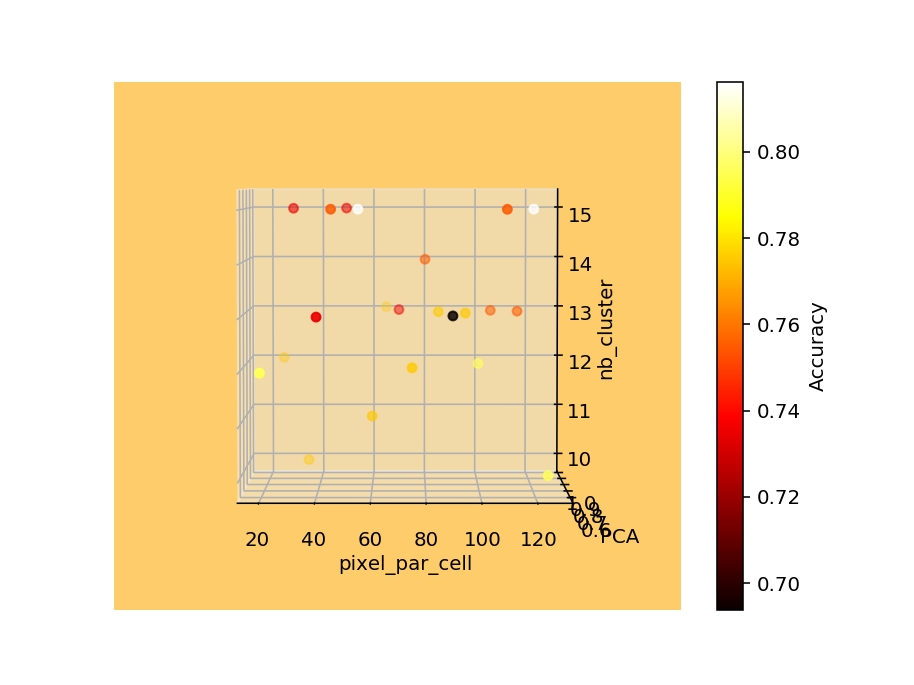

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot=ax.scatter(np.arange(20,130,5)
                , [op_p4[i]["num_pca"]for i in range (len(op_p4)) ]
                , [op_p4[i]["num_cluster"]for i in range (len(op_p4)) ],
                c=op_v4, cmap=plt.hot())
ax.set_xlabel('pixel_par_cell')
ax.set_ylabel('PCA')
ax.set_zlabel('nb_cluster')
ax.set_facecolor((1.0, 0.8, 0.42))
fig.colorbar(plot,label="Accuracy")
plt.show()